## Imports

### Library

In [1]:
# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import datetime as dt
from sklearn.model_selection import train_test_split
%matplotlib inline
# Warnings
import warnings
warnings.filterwarnings('ignore')

# For Timeseries Models - ARIMA, VAR, LSTM
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import grangercausalitytests
from pmdarima import auto_arima

from statsmodels.tsa.api import VAR

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping

### Data

In [2]:
# Importing data from post-EDA saved file.
df = pd.read_csv('./data/post_EDA_df.csv')

# Setting 'Date' column as index
df.set_index('Date', inplace=True)

# Setting the Index as Datetime
df.index = pd.to_datetime(df.index)

In [3]:
# DataFrame check
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2768 entries, 2011-01-03 to 2021-12-30
Data columns (total 67 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Adj_Close_AAPL                  2768 non-null   float64
 1   Volume_AAPL                     2768 non-null   int64  
 2   VWAP_AAPL                       2768 non-null   float64
 3   Adj_Close_AMZN                  2768 non-null   float64
 4   Volume_AMZN                     2768 non-null   int64  
 5   VWAP_AMZN                       2768 non-null   float64
 6   Adj_Close_GOOG                  2768 non-null   float64
 7   Volume_GOOG                     2768 non-null   int64  
 8   VWAP_GOOG                       2768 non-null   float64
 9   Adj_Close_MSFT                  2768 non-null   float64
 10  Volume_MSFT                     2768 non-null   int64  
 11  VWAP_MSFT                       2768 non-null   float64
 12  Adj_Close_QQQ   

## Data preprocessing

### Dropping log % change columns
These columns were engineered for EDA and would not be used for modeling.

In [4]:
# Dropping log daily percentage change & log daily VWAP percentage change columns.
df = df.drop(columns=['log_AAPL_daily_pct_change', 'log_AMZN_daily_pct_change', 'log_GOOG_daily_pct_change', 'log_MSFT_daily_pct_change', 'log_QQQ_daily_pct_change',
                     'log_SPY_daily_pct_change', 'log_VIX_daily_pct_change', 'log_TSLA_daily_pct_change', 'log_AAPL_daily_VWAP_pct_change', 'log_AMZN_daily_VWAP_pct_change',
                     'log_GOOG_daily_VWAP_pct_change', 'log_MSFT_daily_VWAP_pct_change', 'log_QQQ_daily_VWAP_pct_change', 'log_SPY_daily_VWAP_pct_change',
                     'log_TSLA_daily_VWAP_pct_change'])

In [5]:
# Dataframe check after dropping columns in the above cell.
df.head(2)

,Adj_Close_AAPL,Volume_AAPL,VWAP_AAPL,Adj_Close_AMZN,Volume_AMZN,VWAP_AMZN,Adj_Close_GOOG,Volume_GOOG,VWAP_GOOG,Adj_Close_MSFT,...,SPY_daily_pct_change,TSLA_daily_pct_change,VIX_daily_pct_change,AAPL_daily_VWAP_pct_change,AMZN_daily_VWAP_pct_change,GOOG_daily_VWAP_pct_change,MSFT_daily_VWAP_pct_change,QQQ_daily_VWAP_pct_change,SPY_daily_VWAP_pct_change,TSLA_daily_VWAP_pct_change
Date,,,,,,,,,,,,,,,,,,,,,
2011-01-03,10.091493,445138400,11.722262,184.220001,5331400,183.810003,301.04660,4748131,299.945730,22.061134,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-04,10.144161,309080800,11.808810,185.009995,5031800,185.496663,299.93576,3662677,300.277822,22.147865,...,-0.05508,0.187833,-1.306084,0.738318,0.917611,0.110717,0.035681,-0.126546,0.049957,0.150906


### Filling the first row of % change with 0
Resulting dataframe from the above will have the first row of daily adjusted closing price and daily VWAP price cells as Null value due to percentage change calculation.

In [6]:
# Filling in the null values with 0 as there is 0% change for the first row values in percentage change calculation
df.fillna(value=0, inplace=True)

# Dataframe Null value check: making sure no null values. 
df.isnull().sum()

Adj_Close_AAPL                0
Volume_AAPL                   0
VWAP_AAPL                     0
Adj_Close_AMZN                0
Volume_AMZN                   0
VWAP_AMZN                     0
Adj_Close_GOOG                0
Volume_GOOG                   0
VWAP_GOOG                     0
Adj_Close_MSFT                0
Volume_MSFT                   0
VWAP_MSFT                     0
Adj_Close_QQQ                 0
Volume_QQQ                    0
VWAP_QQQ                      0
Adj_Close_SPY                 0
Volume_SPY                    0
VWAP_SPY                      0
Adj_Close_TSLA                0
Volume_TSLA                   0
VWAP_TSLA                     0
Adj_Close_VIX                 0
log_Adj_Close_AAPL            0
log_Adj_Close_AMZN            0
log_Adj_Close_GOOG            0
log_Adj_Close_MSFT            0
log_Adj_Close_QQQ             0
log_Adj_Close_SPY             0
log_Adj_Close_TSLA            0
log_Adj_Close_VIX             0
log_VWAP_AAPL                 0
log_VWAP

In [7]:
# Looking at the first two rows of the dataframe. Notice the cells pertaining to % change are filled with 0.
df.head(2)

,Adj_Close_AAPL,Volume_AAPL,VWAP_AAPL,Adj_Close_AMZN,Volume_AMZN,VWAP_AMZN,Adj_Close_GOOG,Volume_GOOG,VWAP_GOOG,Adj_Close_MSFT,...,SPY_daily_pct_change,TSLA_daily_pct_change,VIX_daily_pct_change,AAPL_daily_VWAP_pct_change,AMZN_daily_VWAP_pct_change,GOOG_daily_VWAP_pct_change,MSFT_daily_VWAP_pct_change,QQQ_daily_VWAP_pct_change,SPY_daily_VWAP_pct_change,TSLA_daily_VWAP_pct_change
Date,,,,,,,,,,,,,,,,,,,,,
2011-01-03,10.091493,445138400,11.722262,184.220001,5331400,183.810003,301.04660,4748131,299.945730,22.061134,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-01-04,10.144161,309080800,11.808810,185.009995,5031800,185.496663,299.93576,3662677,300.277822,22.147865,...,-0.05508,0.187833,-1.306084,0.738318,0.917611,0.110717,0.035681,-0.126546,0.049957,0.150906


### Splitting Dataset

#### Splitting for Time-Series modeling

In [8]:
# finding out length of the entire dataframe. will be performing 80:20 split.
len(df), round(len(df)*0.8), round(len(df)*0.2)

(2768, 2214, 554)

In [9]:
ts_train = df.iloc[:2214]
ts_test = df.iloc[2214:]

In [10]:
# Checking tail/train and head/test to see connectivity. 
ts_train.tail(2)

,Adj_Close_AAPL,Volume_AAPL,VWAP_AAPL,Adj_Close_AMZN,Volume_AMZN,VWAP_AMZN,Adj_Close_GOOG,Volume_GOOG,VWAP_GOOG,Adj_Close_MSFT,...,SPY_daily_pct_change,TSLA_daily_pct_change,VIX_daily_pct_change,AAPL_daily_VWAP_pct_change,AMZN_daily_VWAP_pct_change,GOOG_daily_VWAP_pct_change,MSFT_daily_VWAP_pct_change,QQQ_daily_VWAP_pct_change,SPY_daily_VWAP_pct_change,TSLA_daily_VWAP_pct_change
Date,,,,,,,,,,,,,,,,,,,,,
2019-10-17,57.785580,67585200,58.745833,1787.47998,2647400,1789.449992,1253.069946,952400,1255.444946,136.611832,...,0.294894,0.854668,0.804091,0.304492,0.640395,0.789570,-0.190056,0.321246,0.285877,1.046525
2019-10-18,58.063122,97433600,59.023333,1757.51001,3362500,1766.896647,1245.489990,1352800,1248.486654,134.382065,...,-0.437692,-1.916253,3.335751,0.472374,-1.260351,-0.554249,-1.466214,-0.824638,-0.405325,-1.533829


In [11]:
# Checking tail/train and head/test to see connectivity. 
ts_test.head(2)

,Adj_Close_AAPL,Volume_AAPL,VWAP_AAPL,Adj_Close_AMZN,Volume_AMZN,VWAP_AMZN,Adj_Close_GOOG,Volume_GOOG,VWAP_GOOG,Adj_Close_MSFT,...,SPY_daily_pct_change,TSLA_daily_pct_change,VIX_daily_pct_change,AAPL_daily_VWAP_pct_change,AMZN_daily_VWAP_pct_change,GOOG_daily_VWAP_pct_change,MSFT_daily_VWAP_pct_change,QQQ_daily_VWAP_pct_change,SPY_daily_VWAP_pct_change,TSLA_daily_VWAP_pct_change
Date,,,,,,,,,,,,,,,,,,,,,
2019-10-21,59.070091,87247200,59.901667,1785.660034,2130400,1778.846680,1246.150024,1027200,1247.126343,135.379593,...,0.677895,-1.342671,-1.754386,1.488113,0.676329,-0.108957,-0.007250,0.517297,0.529963,-1.506098
2019-10-22,58.935013,82293600,60.148333,1765.729980,2111700,1772.503337,1242.800049,1023800,1244.926676,133.364960,...,-0.326666,0.820514,3.285715,0.411785,-0.356599,-0.176379,-0.314056,-0.170971,-0.035587,0.207027


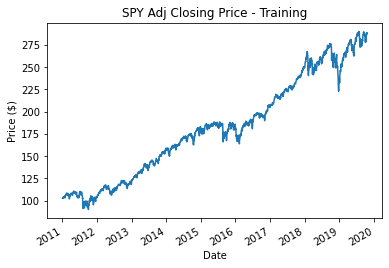

In [12]:
# Quick graph check. Refer to EDA notebook for individual graphs
ts_train['Adj_Close_SPY'].plot()
plt.title('SPY Adj Closing Price - Training')
plt.ylabel('Price ($)');

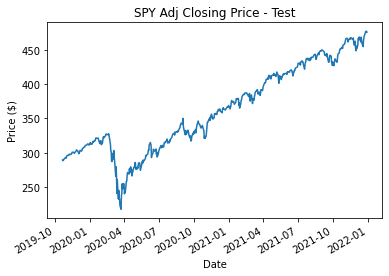

In [13]:
# Quick graph check. Refer to EDA notebook for individual graphs
ts_test['Adj_Close_SPY'].plot()
plt.title('SPY Adj Closing Price - Test')
plt.ylabel('Price ($)');

#### Preparing Dataframe for Train/Test Split

In [14]:
# Creating a copy of dataframe for train/test split
df_tts = df.copy()

# Keeping Adjusted Closing price, Volume, and Daily Percentage Changes only.
df_tts.drop(columns=['VWAP_AAPL', 'VWAP_AMZN', 'VWAP_GOOG', 'VWAP_MSFT', 'VWAP_QQQ', 'VWAP_SPY', 'VWAP_TSLA',
                        'log_Adj_Close_AAPL', 'log_Adj_Close_AMZN', 'log_Adj_Close_GOOG', 'log_Adj_Close_MSFT', 'log_Adj_Close_QQQ', 'log_Adj_Close_SPY', 'log_Adj_Close_TSLA', 'log_Adj_Close_VIX',
                        'log_VWAP_AAPL', 'log_VWAP_AMZN', 'log_VWAP_GOOG', 'log_VWAP_MSFT', 'log_VWAP_QQQ', 'log_VWAP_SPY', 'log_VWAP_TSLA',
                        'AAPL_daily_VWAP_pct_change', 'AMZN_daily_VWAP_pct_change', 'GOOG_daily_VWAP_pct_change', 'MSFT_daily_VWAP_pct_change', 'QQQ_daily_VWAP_pct_change',
                        'QQQ_daily_VWAP_pct_change', 'SPY_daily_VWAP_pct_change', 'TSLA_daily_VWAP_pct_change'], inplace=True)


## Time-Series

### Granger-Causality Test
Granger-Causality Test is used to determine whether a timeseries is useful for forecasting another. Knowing the value of time series A at a certain lag is useful for predicting the value of the time series B at a later time period. This test provides **F-test stat with a corresponding p-value**, which we can determine whether or not to reject the null hypothesis and conclude that we have sufficient evidence to say that thte time series A Granger-causes time series B. 

- Null Hypothesis: Time Series A does not Granger-cause Time Series B
- Alternative Hypothesis: Time Series A Granger-causes Time Series B

In [15]:
# Evaluating Granger-Causality for adjusted closing prices of the stocks.
# Average 253 trading days in a given calendar year. 
grangercausalitytests(df[['Adj_Close_AAPL',  'Adj_Close_SPY']], maxlag=[253]) 


Granger Causality
number of lags (no zero) 253
ssr based F test:         F=3.1151  , p=0.0000  , df_denom=2008, df_num=253
ssr based chi2 test:   chi2=987.1170, p=0.0000  , df=253
likelihood ratio test: chi2=832.7035, p=0.0000  , df=253
parameter F test:         F=3.1151  , p=0.0000  , df_denom=2008, df_num=253


{253: ({'ssr_ftest': (3.1151130802627955, 2.943468647454338e-44, 2008.0, 253),
   'ssr_chi2test': (987.1169708196292, 2.929292214946728e-87, 253),
   'lrtest': (832.7034997184328, 5.670649717275654e-63, 253),
   'params_ftest': (3.1151130802627653, 2.943468647459818e-44, 2008.0, 253.0)},
   array([[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 1., 0., 0.],
          [0., 0., 0., ..., 0., 1., 0.]])])}

Since p value is less than the significance, (0.0000 < 0.05), we can reject the null hypothesis and conclude that knowing the price of SPY is useful for predicting the future price of AAPL.

In [16]:
# Evaluating Granger-Causality for adjusted closing prices of the stocks.
# Average 253 trading days in a given calendar year. 
grangercausalitytests(df[['Adj_Close_AMZN',  'Adj_Close_SPY']], maxlag=[253]) 


Granger Causality
number of lags (no zero) 253
ssr based F test:         F=3.4239  , p=0.0000  , df_denom=2008, df_num=253
ssr based chi2 test:   chi2=1084.9548, p=0.0000  , df=253
likelihood ratio test: chi2=902.0009, p=0.0000  , df=253
parameter F test:         F=3.4239  , p=0.0000  , df_denom=2008, df_num=253


{253: ({'ssr_ftest': (3.423866601305274, 1.2190128140623496e-52, 2008.0, 253),
   'ssr_chi2test': (1084.9547804171011, 2.287633112167919e-103, 253),
   'lrtest': (902.0009293030998, 1.118882042868737e-73, 253),
   'params_ftest': (3.4238666013052566,
    1.2190128140637528e-52,
    2008.0,
    253.0)},
   array([[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 1., 0., 0.],
          [0., 0., 0., ..., 0., 1., 0.]])])}

Since p value is less than the significance, (0.0000 < 0.05), we can reject the null hypothesis and conclude that knowing the price of SPY is useful for predicting the future price of AMZN.

In [17]:
# Evaluating Granger-Causality for adjusted closing prices of the stocks.
# Average 253 trading days in a given calendar year. 
grangercausalitytests(df[['Adj_Close_GOOG',  'Adj_Close_SPY']], maxlag=[253]) 


Granger Causality
number of lags (no zero) 253
ssr based F test:         F=2.0545  , p=0.0000  , df_denom=2008, df_num=253
ssr based chi2 test:   chi2=651.0320, p=0.0000  , df=253
likelihood ratio test: chi2=578.9688, p=0.0000  , df=253
parameter F test:         F=2.0545  , p=0.0000  , df_denom=2008, df_num=253


{253: ({'ssr_ftest': (2.0545066612360996, 2.45128619541653e-17, 2008.0, 253),
   'ssr_chi2test': (651.0320298860678, 6.976870218914812e-37, 253),
   'lrtest': (578.9687808369636, 1.3576724322112156e-27, 253),
   'params_ftest': (2.054506661236161, 2.4512861954086923e-17, 2008.0, 253.0)},
   array([[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 1., 0., 0.],
          [0., 0., 0., ..., 0., 1., 0.]])])}

Since p value is less than the significance, (0.0000 < 0.05), we can reject the null hypothesis and conclude that knowing the price of SPY is useful for predicting the future price of GOOG.

In [18]:
# Evaluating Granger-Causality for adjusted closing prices of the stocks.
# Average 253 trading days in a given calendar year. 
grangercausalitytests(df[['Adj_Close_MSFT',  'Adj_Close_SPY']], maxlag=[253]) 


Granger Causality
number of lags (no zero) 253
ssr based F test:         F=2.6000  , p=0.0000  , df_denom=2008, df_num=253
ssr based chi2 test:   chi2=823.8831, p=0.0000  , df=253
likelihood ratio test: chi2=712.6593, p=0.0000  , df=253
parameter F test:         F=2.6000  , p=0.0000  , df_denom=2008, df_num=253


{253: ({'ssr_ftest': (2.599984652862666, 1.1807143412437696e-30, 2008.0, 253),
   'ssr_chi2test': (823.8830850065985, 1.2317992733711593e-61, 253),
   'lrtest': (712.6593076878871, 2.3358287767733005e-45, 253),
   'params_ftest': (2.5999846528626733,
    1.1807143412432327e-30,
    2008.0,
    253.0)},
   array([[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 1., 0., 0.],
          [0., 0., 0., ..., 0., 1., 0.]])])}

Since p value is less than the significance, (0.0000 < 0.05), we can reject the null hypothesis and conclude that knowing the price of SPY is useful for predicting the future price of MSFT.

In [19]:
# Evaluating Granger-Causality for adjusted closing prices of the stocks.
# Average 253 trading days in a given calendar year. 
grangercausalitytests(df[['Adj_Close_QQQ',  'Adj_Close_SPY']], maxlag=[253]) 


Granger Causality
number of lags (no zero) 253
ssr based F test:         F=2.6882  , p=0.0000  , df_denom=2008, df_num=253
ssr based chi2 test:   chi2=851.8403, p=0.0000  , df=253
likelihood ratio test: chi2=733.6303, p=0.0000  , df=253
parameter F test:         F=2.6882  , p=0.0000  , df_denom=2008, df_num=253


{253: ({'ssr_ftest': (2.6882111991000905, 6.19658630433947e-33, 2008.0, 253),
   'ssr_chi2test': (851.8403112208129, 6.798072530570381e-66, 253),
   'lrtest': (733.6302983374735, 2.447627534424747e-48, 253),
   'params_ftest': (2.6882111990998347, 6.19658630443431e-33, 2008.0, 253.0)},
   array([[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 1., 0., 0.],
          [0., 0., 0., ..., 0., 1., 0.]])])}

Since p value is less than the significance, (0.0000 < 0.05), we can reject the null hypothesis and conclude that knowing the price of SPY is useful for predicting the future price of QQQ.

In [20]:
# Evaluating Granger-Causality for adjusted closing prices of the stocks.
# Average 253 trading days in a given calendar year. 
grangercausalitytests(df[['Adj_Close_TSLA',  'Adj_Close_SPY']], maxlag=[253]) 


Granger Causality
number of lags (no zero) 253
ssr based F test:         F=4.9995  , p=0.0000  , df_denom=2008, df_num=253
ssr based chi2 test:   chi2=1584.2498, p=0.0000  , df=253
likelihood ratio test: chi2=1228.6559, p=0.0000  , df=253
parameter F test:         F=4.9995  , p=0.0000  , df_denom=2008, df_num=253


{253: ({'ssr_ftest': (4.999526187825367, 9.027583121643685e-96, 2008.0, 253),
   'ssr_chi2test': (1584.2497588059473, 3.415066229082068e-191, 253),
   'lrtest': (1228.6558869102537, 8.30778168658965e-128, 253),
   'params_ftest': (4.999526187822856, 9.0275831230541e-96, 2008.0, 253.0)},
   array([[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 1., 0., 0.],
          [0., 0., 0., ..., 0., 1., 0.]])])}

Since p value is less than the significance, (0.0000 < 0.05), we can reject the null hypothesis and conclude that knowing the price of SPY is useful for predicting the future price of TSLA.

In [21]:
# Evaluating Granger-Causality for adjusted closing prices of the stocks.
# Average 253 trading days in a given calendar year. 
grangercausalitytests(df[['Adj_Close_VIX',  'Adj_Close_SPY']], maxlag=[253]) 


Granger Causality
number of lags (no zero) 253
ssr based F test:         F=1.4524  , p=0.0000  , df_denom=2008, df_num=253
ssr based chi2 test:   chi2=460.2327, p=0.0000  , df=253
likelihood ratio test: chi2=422.6444, p=0.0000  , df=253
parameter F test:         F=1.4524  , p=0.0000  , df_denom=2008, df_num=253


{253: ({'ssr_ftest': (1.4523880403763432, 1.498358506230211e-05, 2008.0, 253),
   'ssr_chi2test': (460.23269330242306, 3.1564956912242396e-14, 253),
   'lrtest': (422.6443632875216, 1.1598538839417143e-10, 253),
   'params_ftest': (1.4523880403776661,
    1.4983585061603994e-05,
    2008.0,
    253.0)},
   array([[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 1., 0., 0.],
          [0., 0., 0., ..., 0., 1., 0.]])])}

Since p value is less than the significance, (0.0000 < 0.05), we can reject the null hypothesis and conclude that knowing the price of SPY is useful for predicting the future price of VIX.

In [22]:
# Evaluating Granger-Causality for adjusted closing prices of S&P 500 and Nasdaq
# Average 253 trading days in a given calendar year. 
grangercausalitytests(df[['Adj_Close_SPY', 'Adj_Close_QQQ']], maxlag=[253])


Granger Causality
number of lags (no zero) 253
ssr based F test:         F=1.9598  , p=0.0000  , df_denom=2008, df_num=253
ssr based chi2 test:   chi2=621.0166, p=0.0000  , df=253
likelihood ratio test: chi2=555.0117, p=0.0000  , df=253
parameter F test:         F=1.9598  , p=0.0000  , df_denom=2008, df_num=253


{253: ({'ssr_ftest': (1.9597847571491793, 3.227089671006535e-15, 2008.0, 253),
   'ssr_chi2test': (621.0165548058949, 6.33786496993289e-33, 253),
   'lrtest': (555.0116533643959, 1.1116884052556068e-24, 253),
   'params_ftest': (1.9597847571493563,
    3.2270896709775744e-15,
    2008.0,
    253.0)},
   array([[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 1., 0., 0.],
          [0., 0., 0., ..., 0., 1., 0.]])])}

Since p value is less than the significance, (0.0000 < 0.05), we can reject the null hypothesis and conclude that knowing the price of SPY is useful for predicting the future price of QQQ.

#### Summary
Given the above results of Granger-Causality test, we can conclude that knowing the price of SPY is useful for predicting the future prices of stocks: AAPL, AMZN, GOOG, MSFT, QQQ, TSLA, VIX. This also goes in line with the correlation scores shown in the matrix earlier. While VIX showed low score in the correlation, it is due to VIX being the index of volatility and VIX tends to go opposite direction of the general market trend. 

### ACF & PACF plots
ACF & PACF plots will be observed in this section.

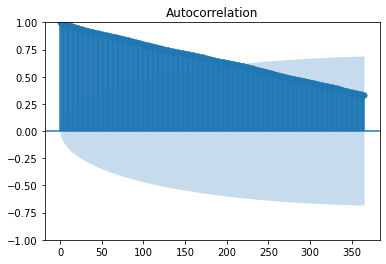

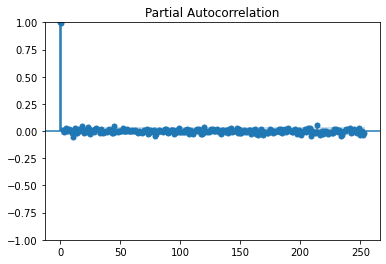

In [23]:
# ACF & PACF plots of adjusted closing price of AAPL. 
plot_acf(df['Adj_Close_AAPL'], lags=365), plt.savefig('./images/ACF_AAPL.png') 
plot_pacf(df['Adj_Close_AAPL'], lags=253), plt.savefig('./images/PACF_AAPL.png');

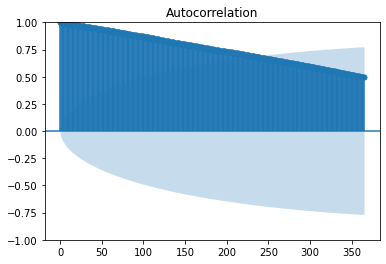

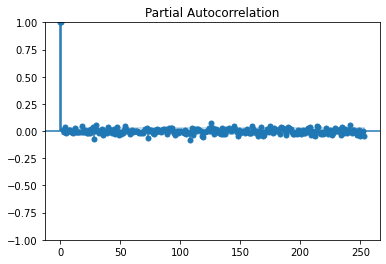

In [24]:
# ACF & PACF plots of adjusted closing price of AMZN. 
plot_acf(df['Adj_Close_AMZN'], lags=365), plt.savefig('./images/ACF_AMZN.png') 
plot_pacf(df['Adj_Close_AMZN'], lags=253), plt.savefig('./images/PACF_AMZN.png');

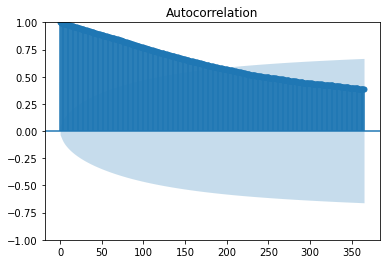

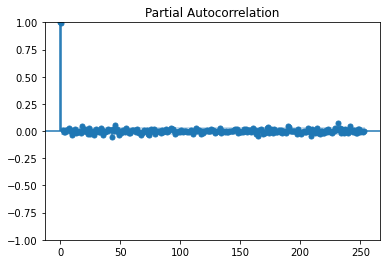

In [25]:
# ACF & PACF plots of adjusted closing price of GOOG. 
plot_acf(df['Adj_Close_GOOG'], lags=365), plt.savefig('./images/ACF_GOOG.png') 
plot_pacf(df['Adj_Close_GOOG'], lags=253), plt.savefig('./images/PACF_GOOG.png');

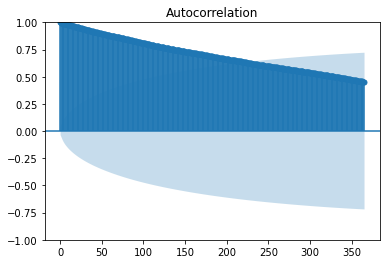

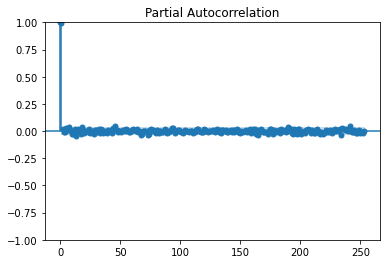

In [26]:
# ACF & PACF plots of adjusted closing price of MSFT. 
plot_acf(df['Adj_Close_MSFT'], lags=365), plt.savefig('./images/ACF_MSFT.png') 
plot_pacf(df['Adj_Close_MSFT'], lags=253), plt.savefig('./images/PACF_MSFT.png');

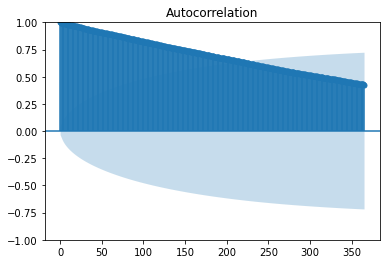

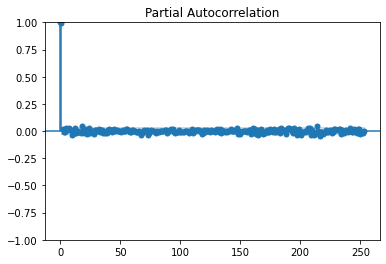

In [27]:
# ACF & PACF plots of adjusted closing price of QQQ. 
plot_acf(df['Adj_Close_QQQ'], lags=365), plt.savefig('./images/ACF_QQQ.png') 
plot_pacf(df['Adj_Close_QQQ'], lags=253), plt.savefig('./images/PACF_QQQ.png');

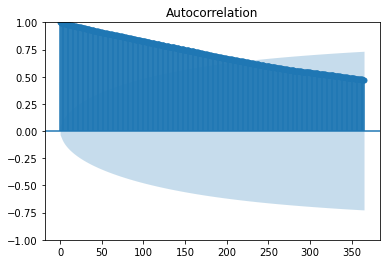

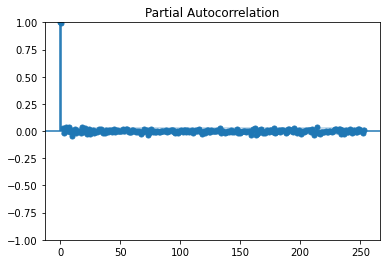

In [28]:
# ACF & PACF plots of adjusted closing price of SPY. 
plot_acf(df['Adj_Close_SPY'], lags=365), plt.savefig('./images/ACF_SPY.png') 
plot_pacf(df['Adj_Close_SPY'], lags=253), plt.savefig('./images/PACF_SPY.png');

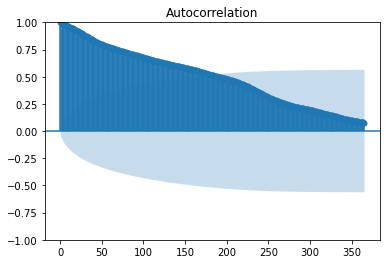

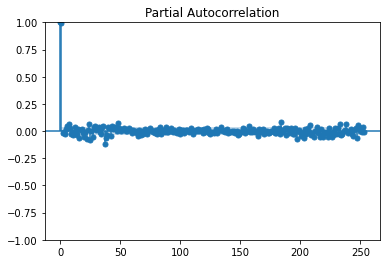

In [29]:
# ACF & PACF plots of adjusted closing price of TSLA. 
plot_acf(df['Adj_Close_TSLA'], lags=365), plt.savefig('./images/ACF_TSLA.png') 
plot_pacf(df['Adj_Close_TSLA'], lags=253), plt.savefig('./images/PACF_TSLA.png');

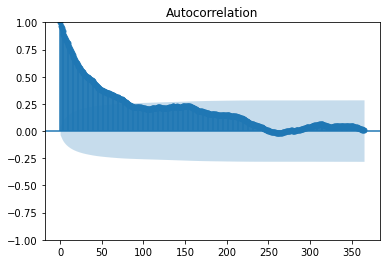

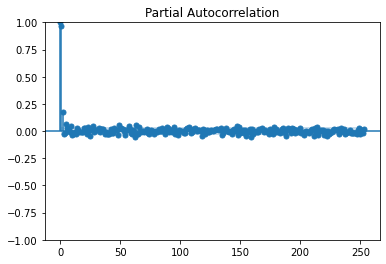

In [30]:
# ACF & PACF plots of adjusted closing price of VIX. 
plot_acf(df['Adj_Close_VIX'], lags=365), plt.savefig('./images/ACF_VIX.png') 
plot_pacf(df['Adj_Close_VIX'], lags=253), plt.savefig('./images/PACF_VIX.png');

#### Summary
Based on ACF & PACF plots in the above, adjusted closing prices of stocks AAPL, AMZN, GOOG, MSFT, QQQ, SPY, and TSLA are shown to be non-stationary.<br>
**VIX seems it needs more investigation** into the data. **Seasonal Decomposition and ADFuller test** will follow. 

### Seasonal Decomposition
Seasonal decomposition using moving averages. Returns an object with seasonal, trend, and resid attributes.

In Time-Series data, **seasonality** describes when a times series is afffected by factors that take on a **fixed and known frequency**. Seasonality does not have to explicitly refer to seasons of the year, but it would mostly be tied to some meaning on the calendar. By default, the decomposition will assume a linear trend. If the trend is an exponential trend, then model should be multiplicative, but this will fail with values that are <= 0. 

Reference: Linear Time Series Modeling Lecture, General Assembly

In [31]:
# Defining a function that takes a variable of sotkc name to obtain seasonal decomposition. 
def get_seasonal_decompose(ticker):
    # Save the plot as figure
    plt.savefig(f'./images/seasonal_decomposition_{ticker}.png')
    
    return seasonal_decompose(df[f'Adj_Close_{ticker}'], period=253).plot();

<Figure size 432x288 with 0 Axes>

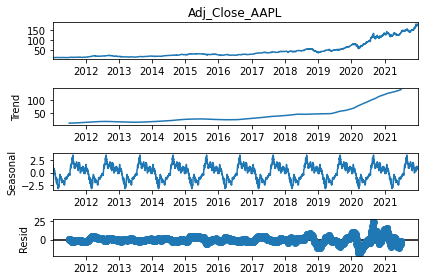

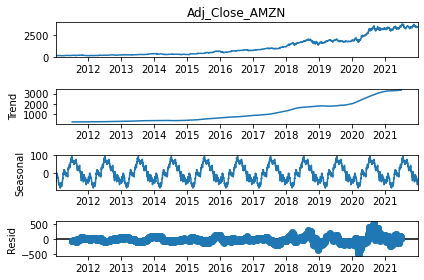

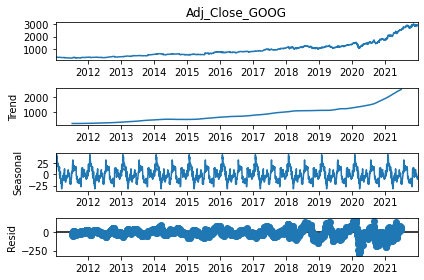

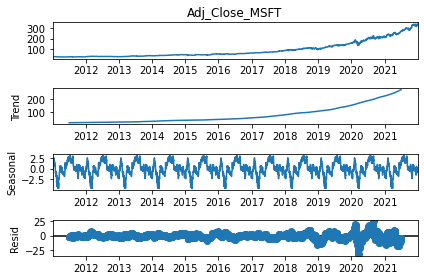

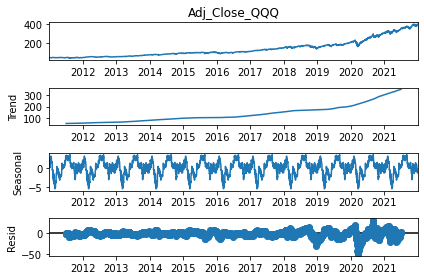

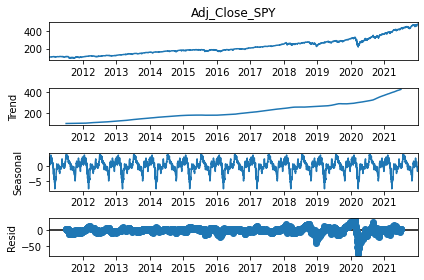

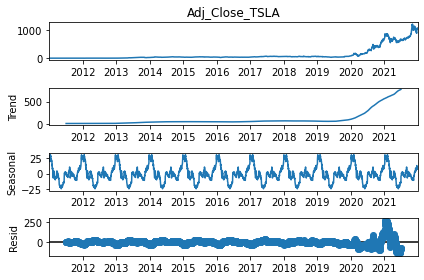

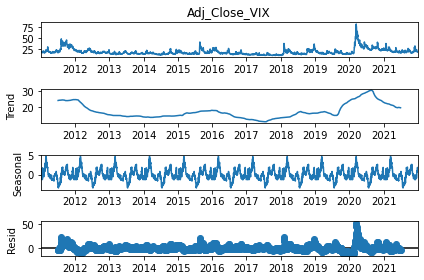

In [32]:
# Obtaining Seasonal decompose for all tickers
get_seasonal_decompose('AAPL');
get_seasonal_decompose('AMZN');
get_seasonal_decompose('GOOG');
get_seasonal_decompose('MSFT');
get_seasonal_decompose('QQQ');
get_seasonal_decompose('SPY');
get_seasonal_decompose('TSLA');
get_seasonal_decompose('VIX');

Seasonality was investigated using seasonal_decompose from statsmodels. As seen in the above plots, when the period is set as 253, which is the average trading days in a year, we can clearly see the seasonality in the each ticker names yearly. 

### Aguented Dickey-Fuller Test

- Used to test for a unit root in a univariate process in the presence of serial correlation.
- It is a hypothesis test that tests for **stationarity**. An assumption is made that the data are not stationary. With enough evidence, we may accept taht the data are stationary. 
- Returns: adf (test stat.), p-value, usedlag, nobs, critical values (dict), icbest, resstore.
- If Test statistic (adf) < Critical values (dict), we can reject Null Hypothesis at that level of significance.

$$
\begin{eqnarray}
&H_0:& \text{not stationary} \\
&H_A:& \text{stationary}
\end{eqnarray}
$$
More information can be obtained from:
```python
help(adfuller)
```

Stock prices will be tested for stationarity using ADFuller Test.
- $p$-value is compared to $\alpha$, which us often set at 0.10, 0.05, or 0.01. 
- Here, $\alpha$ will be set as 0.05. **5% significance**. 
- If $p$-value > $\alpha$, we cannot accept accept that the given series is stationary: cannot reject null hypothesis.

References:
- https://machinelearningmastery.com/time-series-data-stationary-python/
- https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html

In [33]:
# Building a function to interpret Augmented Dickey-Fuller Test Results.
# Code modified from a reference code learned from the class. Reference: written by J. Nelson.

def adf_test_results(df):
    test_result = pd.Series(df[0:2], index=['Test Statistic (adf)', 'p-value'])
    return test_result

In [34]:
ticker_list = ['AAPL', 'AMZN', 'GOOG', 'MSFT', 'QQQ', 'SPY', 'TSLA']

# Building a function that returns a dataframe with the index as ticker name and columns for test stats and p-values.
def adf_results(ticker_list):
    # Empty lists as placeholder. Results will be added here
    test_stats = []
    p_values = []
    test_stats_vwap = []
    p_values_vwap = []
    
    for ticker in ticker_list:
        # Codes that will add results to the above lists - Adj Close Price
        test_stats.append(adf_test_results(adfuller(ts_train[f'Adj_Close_{ticker}']))[0])
        p_values.append(adf_test_results(adfuller(ts_train[f'Adj_Close_{ticker}']))[1])
        # VWAP
        test_stats_vwap.append(adf_test_results(adfuller(ts_train[f'VWAP_{ticker}']))[0])
        p_values_vwap.append(adf_test_results(adfuller(ts_train[f'VWAP_{ticker}']))[1])
        
    # Code that will return the results as a dataframe. 
    return pd.DataFrame(list(zip(test_stats, p_values, test_stats_vwap, p_values_vwap)), columns=['Test_Stat_(Adj_close)', 'p-value_(Adj_close)', 'Test_Stat_(VWAP)', 'p-value_(VWAP)'], index=ticker_list)

df_adf = adf_results(ticker_list)

In [35]:
df_adf['Hypothesis_Adj_Close'] = ['Reject' if p>0.05 else 'Accept' for p in df_adf['p-value_(Adj_close)']]
df_adf['Hypothesis_VWAP'] = ['Reject' if p>0.05 else 'Accept' for p in df_adf['p-value_(VWAP)']]

# Reordering the columns
df_adf = df_adf[['Test_Stat_(Adj_close)', 'p-value_(Adj_close)', 'Hypothesis_Adj_Close', 'Test_Stat_(VWAP)', 'p-value_(VWAP)', 'Hypothesis_VWAP']]
# ADF test results 
df_adf

,Test_Stat_(Adj_close),p-value_(Adj_close),Hypothesis_Adj_Close,Test_Stat_(VWAP),p-value_(VWAP),Hypothesis_VWAP
AAPL,0.192695,0.971849,Reject,-0.043369,0.954795,Reject
AMZN,0.395822,0.981338,Reject,0.488344,0.984514,Reject
GOOG,0.080608,0.964712,Reject,0.203343,0.972448,Reject
MSFT,2.817629,1.000000,Reject,2.542088,0.999062,Reject
QQQ,0.591425,0.987402,Reject,0.395331,0.981319,Reject
SPY,0.191992,0.971809,Reject,-0.135185,0.945819,Reject
TSLA,-1.689426,0.436569,Reject,-1.592528,0.487346,Reject


In [36]:
# VIX ADFuller test results
adf_test_results(adfuller(ts_train['Adj_Close_VIX']))[0], adf_test_results(adfuller(ts_train['Adj_Close_VIX']))[1]

(-4.531120613060356, 0.00017268805308607435)

In [37]:
# Manually adding VIX ADFuller results to the df_adf. VIX does not have trade volume, hence we cannot use the same function from the above.
VIX_row = pd.Series({'Test_Stat_(Adj_close)':adf_test_results(adfuller(ts_train['Adj_Close_VIX']))[0], 
                     'p-value_(Adj_close)':adf_test_results(adfuller(ts_train['Adj_Close_VIX']))[1],
                    'Hypothesis_Adj_Close':'Accept'}, name='VIX')
df_adf = df_adf.append(VIX_row)
df_adf

,Test_Stat_(Adj_close),p-value_(Adj_close),Hypothesis_Adj_Close,Test_Stat_(VWAP),p-value_(VWAP),Hypothesis_VWAP
AAPL,0.192695,0.971849,Reject,-0.043369,0.954795,Reject
AMZN,0.395822,0.981338,Reject,0.488344,0.984514,Reject
GOOG,0.080608,0.964712,Reject,0.203343,0.972448,Reject
MSFT,2.817629,1.000000,Reject,2.542088,0.999062,Reject
QQQ,0.591425,0.987402,Reject,0.395331,0.981319,Reject
SPY,0.191992,0.971809,Reject,-0.135185,0.945819,Reject
TSLA,-1.689426,0.436569,Reject,-1.592528,0.487346,Reject
VIX,-4.531121,0.000173,Accept,NaN,NaN,NaN


As seen in the above dataframe, all stocks show extremely high $p$-value, suggesting that:
1. We cannot reject the null hypothesis and the **data (Stock Prices) are non-stationary**.; We would need an integraded model for forecasting.
2. VIX shows extremely low $p$-value of 0.000173. We can reject the null hypothesis and accept the alternative hypothesis at **5% significance ($\alpha$ = 0.05)** that VIX is stationary.
3. Again, there is no traded volume on VIX in the dataset obtained from Yahoo Finance. Hence, there is no VWAP calculated for VIX. 

Insight on VIX: 
- VIX is Chicago Board Options Exchange Volatility Index. 
- While it is not essentialy an inverse of the market performance, it often shows the inverse relationship with the general market performance. 
- VIX goes down when the market performs well, indicating the market is stable. VIX goes up when the market is performing poorly and there is increased volatility. 

### Differencing Data for Stationarity
As observed in the above, our data is non-stationary (except VIX) at this time. Will diffrence the data for stationarity. 

In [38]:
# Creating a copy of the original dataframe for diffrencing
df_for_diff = df.copy()

# First-Differencing dataframe and dropping null values
df_for_diff = df_for_diff.diff().dropna()

In [39]:
# Quick resulting dataframe check. Notice the first row is 2011-01-04 now, instead of 2011-01-03.
df_for_diff.head(1)

,Adj_Close_AAPL,Volume_AAPL,VWAP_AAPL,Adj_Close_AMZN,Volume_AMZN,VWAP_AMZN,Adj_Close_GOOG,Volume_GOOG,VWAP_GOOG,Adj_Close_MSFT,...,SPY_daily_pct_change,TSLA_daily_pct_change,VIX_daily_pct_change,AAPL_daily_VWAP_pct_change,AMZN_daily_VWAP_pct_change,GOOG_daily_VWAP_pct_change,MSFT_daily_VWAP_pct_change,QQQ_daily_VWAP_pct_change,SPY_daily_VWAP_pct_change,TSLA_daily_VWAP_pct_change
Date,,,,,,,,,,,,,,,,,,,,,
2011-01-04,0.052669,-136057600.0,0.086548,0.789993,-299600.0,1.686661,-1.11084,-1085454.0,0.332092,0.086731,...,-0.05508,0.187833,-1.306084,0.738318,0.917611,0.110717,0.035681,-0.126546,0.049957,0.150906


In [40]:
ticker_list = ['AAPL', 'AMZN', 'GOOG', 'MSFT', 'QQQ', 'SPY', 'TSLA']

# Building a function that returns a dataframe with the index as ticker name and columns for test stats and p-values.
def adf_results_diff(ticker_list):
    # Empty lists as placeholder. Results will be added here
    test_stats_diff = []
    p_values_diff = []
    test_stats_vwap_diff = []
    p_values_vwap_diff = []
    
    for ticker in ticker_list:
        # Codes that will add results to the above lists - Adj Close Price
        test_stats_diff.append(adf_test_results(adfuller(df_for_diff[f'Adj_Close_{ticker}']))[0])
        p_values_diff.append(adf_test_results(adfuller(df_for_diff[f'Adj_Close_{ticker}']))[1])
        # VWAP
        test_stats_vwap_diff.append(adf_test_results(adfuller(df_for_diff[f'VWAP_{ticker}']))[0])
        p_values_vwap_diff.append(adf_test_results(adfuller(df_for_diff[f'VWAP_{ticker}']))[1])
        
    # Code that will return the results as a dataframe. 
    return pd.DataFrame(list(zip(test_stats_diff, p_values_diff, test_stats_vwap_diff, p_values_vwap_diff)), columns=['Test_Stat_(Adj_close)_diff', 'p-value_(Adj_close)_diff', 'Test_Stat_(VWAP)_diff', 'p-value_(VWAP)_diff'], index=ticker_list)

df_adf_diff = adf_results_diff(ticker_list)

In [41]:
df_adf_diff['Hypothesis_Adj_Close_diff'] = ['Reject' if p>0.05 else 'Accept' for p in df_adf_diff['p-value_(Adj_close)_diff']]
df_adf_diff['Hypothesis_VWAP_diff'] = ['Reject' if p>0.05 else 'Accept' for p in df_adf_diff['p-value_(VWAP)_diff']]

# Reordering the columns
df_adf_diff = df_adf_diff[['Test_Stat_(Adj_close)_diff', 'p-value_(Adj_close)_diff', 'Hypothesis_Adj_Close_diff', 'Test_Stat_(VWAP)_diff', 'p-value_(VWAP)_diff', 'Hypothesis_VWAP_diff']]

# Manually adding VIX ADFuller results to the df_adf.
VIX_row = pd.Series({'Test_Stat_(Adj_close)_diff':adf_test_results(adfuller(df_for_diff['Adj_Close_VIX']))[0], 
                     'p-value_(Adj_close)_diff':adf_test_results(adfuller(df_for_diff['Adj_Close_VIX']))[1],
                    'Hypothesis_Adj_Close_diff':'Accept'}, name='VIX')
df_adf_diff = df_adf_diff.append(VIX_row)

# First-Differenced ADF test results 
df_adf_diff

,Test_Stat_(Adj_close)_diff,p-value_(Adj_close)_diff,Hypothesis_Adj_Close_diff,Test_Stat_(VWAP)_diff,p-value_(VWAP)_diff,Hypothesis_VWAP_diff
AAPL,-9.977448,2.158722e-17,Accept,-9.135621,2.941233e-15,Accept
AMZN,-12.271639,8.613920e-23,Accept,-12.163043,1.478570e-22,Accept
GOOG,-11.501078,4.490178e-21,Accept,-10.666556,4.272548e-19,Accept
MSFT,-13.656420,1.550678e-25,Accept,-13.714356,1.220812e-25,Accept
QQQ,-12.945363,3.464890e-24,Accept,-12.943558,3.493685e-24,Accept
SPY,-11.219334,2.031932e-20,Accept,-11.261913,1.614215e-20,Accept
TSLA,-9.863107,4.182127e-17,Accept,-9.921775,2.977837e-17,Accept
VIX,-12.301656,7.426742e-23,Accept,NaN,NaN,NaN


As seen in the above, after first-differencing, we are noticing extremely low $p$-values (lower than $\alpha$), suggesting that:
1. We can reject the null hypothesis and state the **data (Stock Prices) are stationary after first-differencing**.
2. Again, there is no traded volume on VIX in the dataset obtained from Yahoo Finance. Hence, there is no VWAP calculated for VIX.

## ARIMA/Auto ARIMA/SARIMA models
AutoRegressive Integrated Moving Average model is a statistical analysis model that the future trend based on the provided historical time-series data. <br>
In order to find the best performing model, **AR(p), I(d), MA(q)** values are differentiated and fitted. This process is usually done manually in the class settings. Here, the process will be automated using **Auto-ARIMA model**.

- AutoRegressive (p): the number of lag observations in the model; also known as the lag order (AR)
- Integrated (d): Frequency of differentiation of raw observations.
- Moving Average (q): Order of Moving Average.

Expectation: The correct model would yield the highest Log-Likelihood and require the lowest AIC. <br>
For more detail, refer to the excerpt from the auto ARIMA documentation: auto-ARIMA optimizes for a given ``information_criterion``, one of ('aic', 'aicc', 'bic', 'hqic', 'oob') (Akaike Information Criterion, Corrected Akaike Information Criterion,Bayesian Information Criterion, Hannan-Quinn Information Criterion, or "out of bag"--for validation scoring--respectively) and returns the ARIMA which minimizes the value.

Reference: https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/

#### Building a function for Auto-ARIMA models

In [42]:
def auto_arima_work(ticker):
    print('*' * 70)
    print(f'This is auto-ARIMA model for {ticker}')
    ticker=str(ticker)
    # Instantiate the moadel
    model = auto_arima(ts_train[f'Adj_Close_{ticker}'], test='adf')
    # Show model summary
    print(model.summary())

    # Plotting diagnostics
    model.plot_diagnostics(figsize=(10,8))
    plt.show()

    # Forecasting. Train set has 2214 rows and Test set has 554 rows.
    forecast, conf_int = model.predict(n_periods=554, return_conf_int=True)

    # Creating series for forecasting
    forecast_series = pd.Series(forecast, index=ts_test.index)
    lower_bound = pd.Series(conf_int[:, 0], index=ts_test.index)
    upper_bound = pd.Series(conf_int[:, 1], index=ts_test.index)

    # Plotting
    plt.figure(figsize=(10,8))
    plt.plot(ts_train[f'Adj_Close_{ticker}'], label='Train (Actual Data)')
    plt.plot(ts_test[f'Adj_Close_{ticker}'], label='Test (Actual Data)')
    plt.plot(forecast_series, color='black', label='Forecast Price (Auto-ARIMA)')
    plt.fill_between(x=ts_test.index, y1=lower_bound, y2=upper_bound, color='k', alpha=0.15)
    plt.plot(lower_bound, color='r', label='Forecast Lowerbound')
    plt.plot(upper_bound, color='g', label='Forecast Upperbound')
    plt.grid()
    plt.title(f'Stock Price for {ticker}', size=20)
    plt.xlabel('Time', size=14)
    plt.ylabel('Price ($)', size=14)
    plt.legend()
    
    # Saving the forecast plot
    plt.savefig(f'./images/Auto_ARIMA_fc_{ticker}.png');

#### AAPL - Apple

**********************************************************************
This is auto-ARIMA model for AAPL
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2214
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1476.905
Date:                Sat, 05 Feb 2022   AIC                           2957.811
Time:                        15:48:09   BIC                           2969.215
Sample:                             0   HQIC                          2961.977
                               - 2214                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0217      0.010      2.133      0.033       0.002       0.042
sigma2         0.2224     

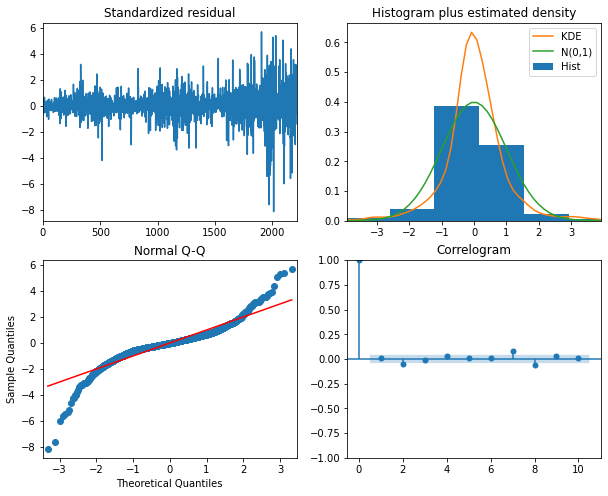

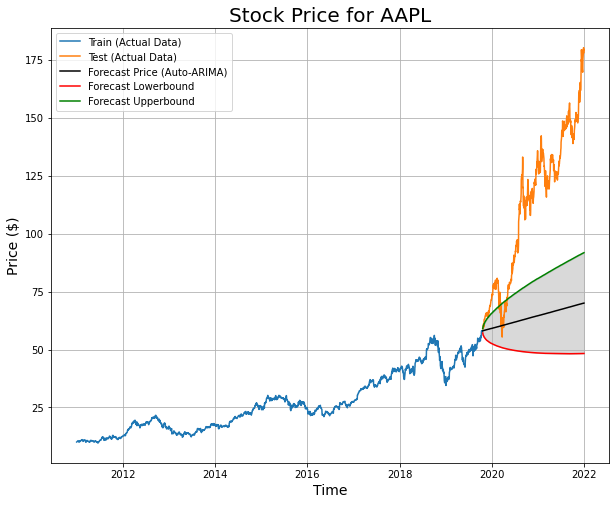

In [43]:
auto_arima_work('AAPL')

- Standardized Residual: The residual errors seem to fluctuate around a mean of zero and have nearly uniform variance with a trend of becoming non-uniform over time. 
- The Density Plot: suggets normal distribution with mean of zero. 
- Normal Q-Q Plot: The dots should fall along the red line. Anything deviating from the red line significantly implies skewed distribution. 
- Correlogram: This is ACF plot showing the residual errors that are not autocorrelated. An autocorrelation would imply an existing pattern in the residual errors that cannot be explained by the model. 

AAPL stock price shows exponential growth far above the forecast upper boundary. It will be worthwile to revisit the time series model with shorter period of data being trained to investigate the recent price upspikes with volatility to be better included in the training model. 

#### AMZN - Amazon

**********************************************************************
This is auto-ARIMA model for AMZN
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2214
Model:               SARIMAX(3, 1, 2)   Log Likelihood               -9352.309
Date:                Sat, 05 Feb 2022   AIC                          18718.619
Time:                        15:48:25   BIC                          18758.533
Sample:                             0   HQIC                         18733.199
                               - 2214                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.7143      0.319      2.240      0.025       0.089       1.339
ar.L1          1.0599     

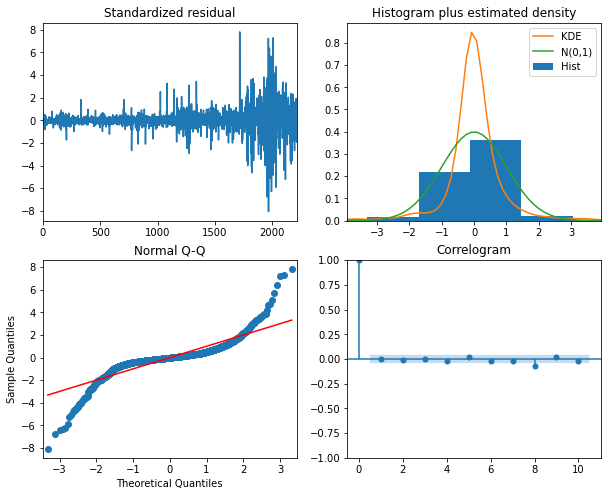

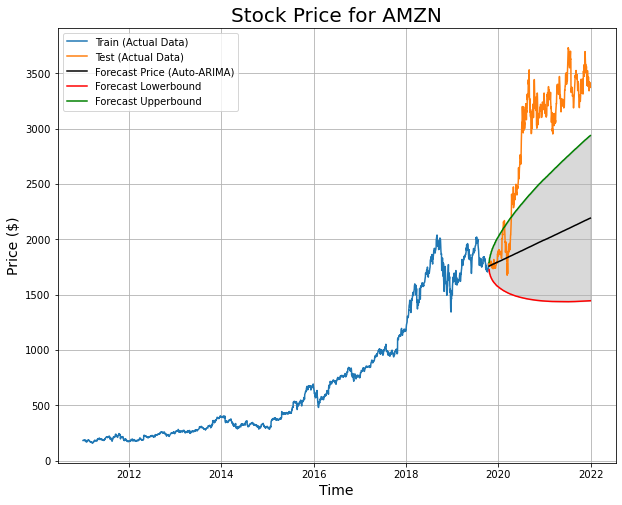

In [44]:
auto_arima_work('AMZN')

- Standardized Residual: The residual errors seem to fluctuate around a mean of zero and have nearly uniform variance with a trend of becoming non-uniform over time. 
- The Density Plot: suggets normal distribution with mean of zero. 
- Normal Q-Q Plot: The dots should fall along the red line. Anything deviating from the red line significantly implies skewed distribution. 
- Correlogram: This is ACF plot showing the residual errors that are not autocorrelated. An autocorrelation would imply an existing pattern in the residual errors that cannot be explained by the model. 

AMZN shows the stock price hovering around the forcasted price and upper boundary of the forecast (from confidence interval), quite decently predicting the stock price until early 2020. Later on, AMZN shows explosive growth far above the upper boundary as well. It would also be worthwhile to revisit with shorter time period being trained to investigate recent price spikes with volatility to be better included in the training model. 

#### GOOG - Alphabet, Inc. (Google)

**********************************************************************
This is auto-ARIMA model for GOOG
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2214
Model:               SARIMAX(2, 1, 2)   Log Likelihood               -8463.660
Date:                Sat, 05 Feb 2022   AIC                          16939.321
Time:                        15:48:34   BIC                          16973.533
Sample:                             0   HQIC                         16951.819
                               - 2214                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1105      0.053      2.104      0.035       0.008       0.213
ar.L1          0.1775     

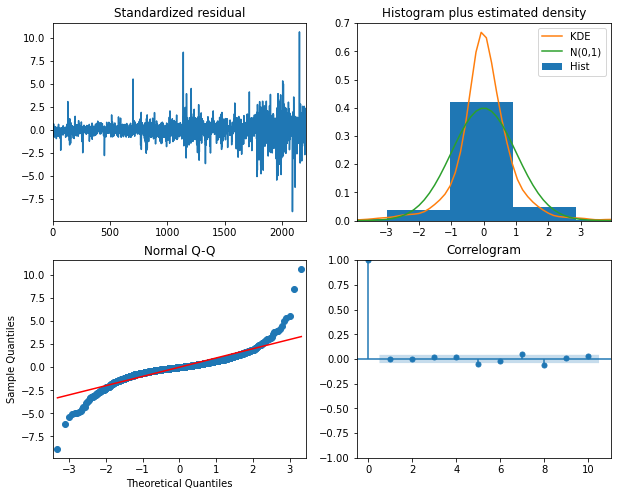

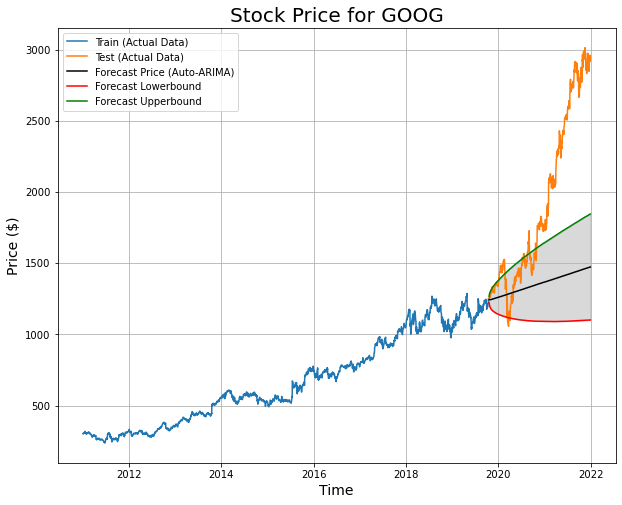

In [45]:
auto_arima_work('GOOG')

- Standardized Residual: The residual errors seem to fluctuate around a mean of zero and have nearly uniform variance with a trend of becoming non-uniform over time. 
- The Density Plot: suggets normal distribution with mean of zero. 
- Normal Q-Q Plot: The dots should fall along the red line. Anything deviating from the red line significantly implies skewed distribution. 
- Correlogram: This is ACF plot showing the residual errors that are not autocorrelated. An autocorrelation would imply an existing pattern in the residual errors that cannot be explained by the model. 

GOOG shows the stock price hovering around the forcasted price and upper boundary of the forecast (from confidence interval), quite decently predicting the stock price until mid GOOG. Later on, GOOG shows explosive growth far above the upper boundary as well. It would also be worthwhile to revisit with shorter time period being trained to investigate recent price spikes with volatility to be better included in the training model. 

#### MSFT - Microsoft

**********************************************************************
This is auto-ARIMA model for MSFT
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2214
Model:               SARIMAX(2, 1, 2)   Log Likelihood               -2861.276
Date:                Sat, 05 Feb 2022   AIC                           5734.552
Time:                        15:48:43   BIC                           5768.765
Sample:                             0   HQIC                          5747.050
                               - 2214                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1186      0.042      2.838      0.005       0.037       0.201
ar.L1         -0.5795     

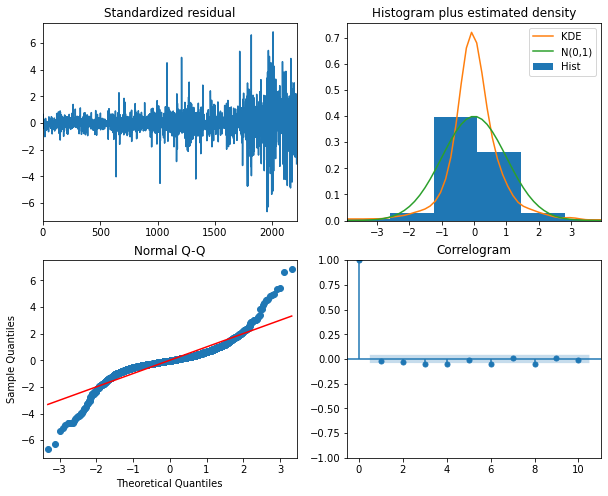

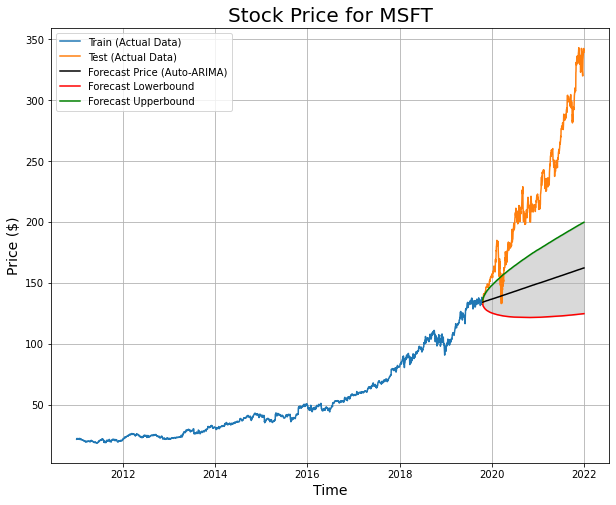

In [46]:
auto_arima_work('MSFT')

- Standardized Residual: The residual errors seem to fluctuate around a mean of zero and have nearly uniform variance with a trend of becoming non-uniform over time. 
- The Density Plot: suggets normal distribution with mean of zero. 
- Normal Q-Q Plot: The dots should fall along the red line. Anything deviating from the red line significantly implies skewed distribution. 
- Correlogram: This is ACF plot showing the residual errors that are not autocorrelated. An autocorrelation would imply an existing pattern in the residual errors that cannot be explained by the model. 

MSFT shows the stock price movements with quite a volatility, spiking above the forecast price boundaries, shortly coming back to the prediced price in early 2020, then exponentially growing afterwards. It would also be worthwhile to revisit with shorter time period being trained to investigate recent price spikes with volatility to be better included in the training model. 

#### QQQ - Invesco QQQ Trust Series 1, Nasdaq-100 Index

**********************************************************************
This is auto-ARIMA model for QQQ
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2214
Model:               SARIMAX(4, 1, 4)   Log Likelihood               -3582.004
Date:                Sat, 05 Feb 2022   AIC                           7184.008
Time:                        15:49:17   BIC                           7241.029
Sample:                             0   HQIC                          7204.838
                               - 2214                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0120      0.004      3.029      0.002       0.004       0.020
ar.L1         -0.5378      

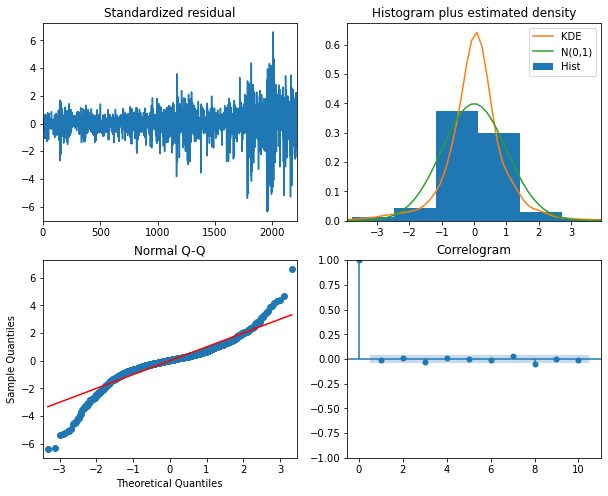

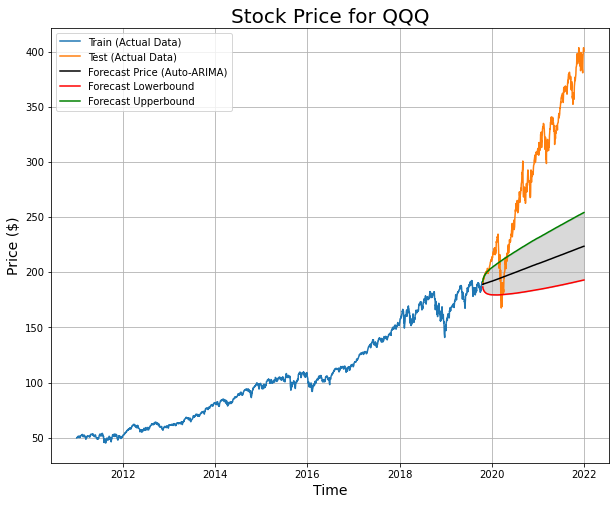

In [47]:
auto_arima_work('QQQ')

- Standardized Residual: The residual errors seem to fluctuate around a mean of zero and have nearly uniform variance with a trend of becoming non-uniform over time. 
- The Density Plot: suggets normal distribution with mean of zero. 
- Normal Q-Q Plot: The dots should fall along the red line. Anything deviating from the red line significantly implies skewed distribution. 
- Correlogram: This is ACF plot showing the residual errors that are not autocorrelated. An autocorrelation would imply an existing pattern in the residual errors that cannot be explained by the model. 

Nasdaq Index ETF, QQQ, shows the price movements with quite a volatility as well, spiking above and below the forecast boundaries in early 2020, then exponentially growing afterwards. 
It would also be worthwhile to revisit with shorter time period being trained to investigate recent price spikes with volatility to be better included in the training model. 

#### SPY - SPDR S&P 500 EFT Trust

**********************************************************************
This is auto-ARIMA model for SPY
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2214
Model:               SARIMAX(1, 0, 1)   Log Likelihood               -4210.575
Date:                Sat, 05 Feb 2022   AIC                           8427.151
Time:                        15:49:26   BIC                           8444.258
Sample:                             0   HQIC                          8433.400
                               - 2214                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000   6.92e-05   1.44e+04      0.000       1.000       1.000
ma.L1         -0.0275      

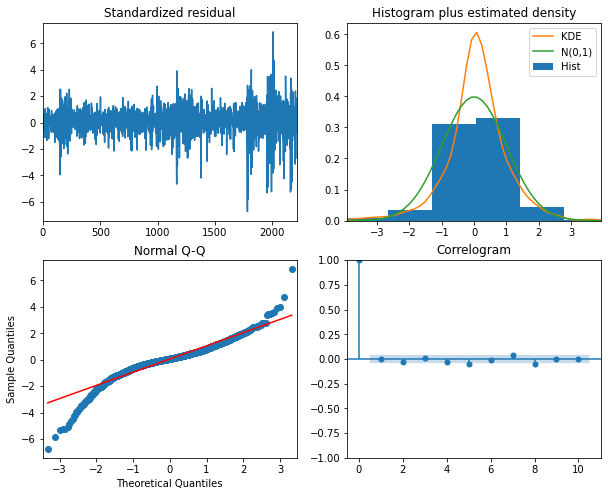

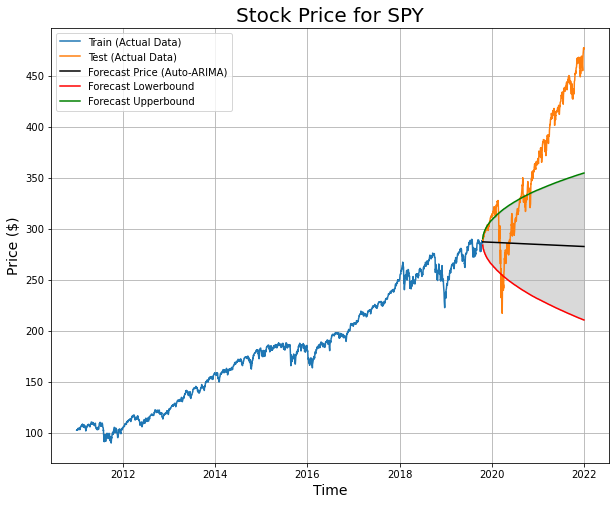

In [48]:
auto_arima_work('SPY')

- Standardized Residual: The residual errors seem to fluctuate around a mean of zero and have nearly uniform variance with a trend of becoming non-uniform over time. 
- The Density Plot: suggets normal distribution with mean of zero. 
- Normal Q-Q Plot: The dots should fall along the red line. Anything deviating from the red line significantly implies skewed distribution. 
- Correlogram: This is ACF plot showing the residual errors that are not autocorrelated. An autocorrelation would imply an existing pattern in the residual errors that cannot be explained by the model. 

Standard and Poor (S%P) 500 shows the price movements with quite a volatility as well, spiking above and below the forecast price boundaries in early 2020, then progressively growing towards the upper boundary and beyond mid-2020 and onwards. It would also be worthwhile to revisit with shorter time period being trained to investigate recent price spikes with volatility to be better included in the training model. 

#### TSLA - Tesla

**********************************************************************
This is auto-ARIMA model for TSLA
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2214
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -3655.957
Date:                Sat, 05 Feb 2022   AIC                           7313.913
Time:                        15:49:29   BIC                           7319.615
Sample:                             0   HQIC                          7315.996
                               - 2214                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         1.5939      0.021     77.054      0.000       1.553       1.634
Ljung-Box (L1) (Q):       

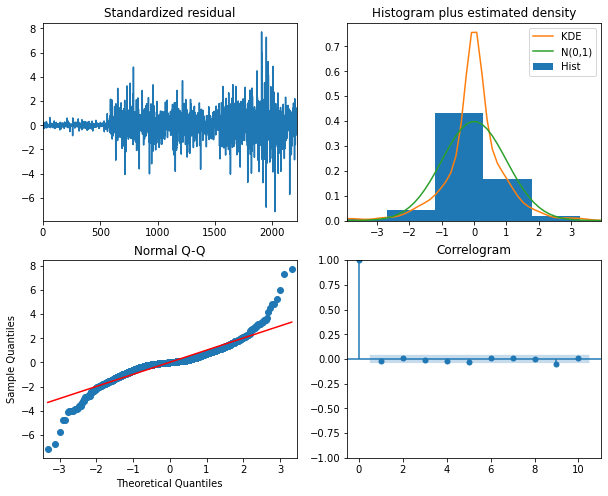

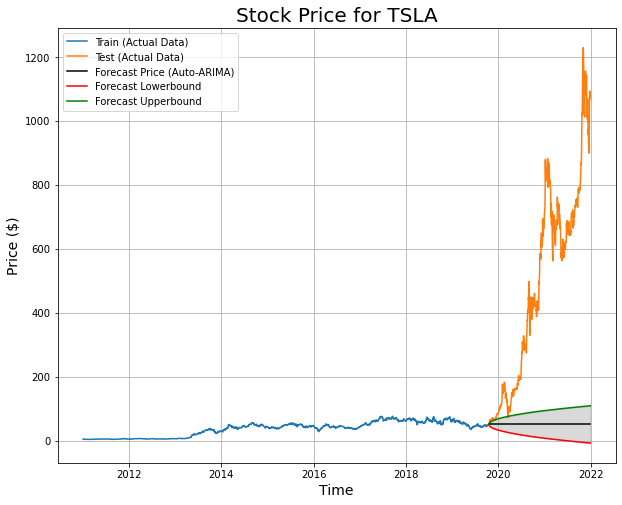

In [49]:
auto_arima_work('TSLA')

- Standardized Residual: The residual errors seem to fluctuate around a mean of zero and have nearly uniform variance with a trend of becoming non-uniform over time. 
- The Density Plot: suggets normal distribution with mean of zero. 
- Normal Q-Q Plot: The dots should fall along the red line. Anything deviating from the red line significantly implies skewed distribution. 
- Correlogram: This is ACF plot showing the residual errors that are not autocorrelated. An autocorrelation would imply an existing pattern in the residual errors that cannot be explained by the model. 

TSLA is one of the most unpredictable stocks otu there with such great volatility. As seen in the price plot, the company underwent exponential growth since late 2019 and onwards, followed by 5:1 stock split in 2020, which dramatically led the growth of the company. Not only the stock prices data itself is non-stationary at baseline, this ticker is also heavily affected by unexpected events, such as Elon Musk's twitter twits, other rival EV companies' making their debut, policy changes and etc. It would be interesting to see if the model can better predict the price movement with price data from late 2019 onwards. 

#### VIX

**********************************************************************
This is auto-ARIMA model for VIX
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2214
Model:               SARIMAX(3, 0, 2)   Log Likelihood               -4113.431
Date:                Sat, 05 Feb 2022   AIC                           8240.861
Time:                        15:49:46   BIC                           8280.779
Sample:                             0   HQIC                          8255.443
                               - 2214                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0857      0.035      2.450      0.014       0.017       0.154
ar.L1          0.8959      

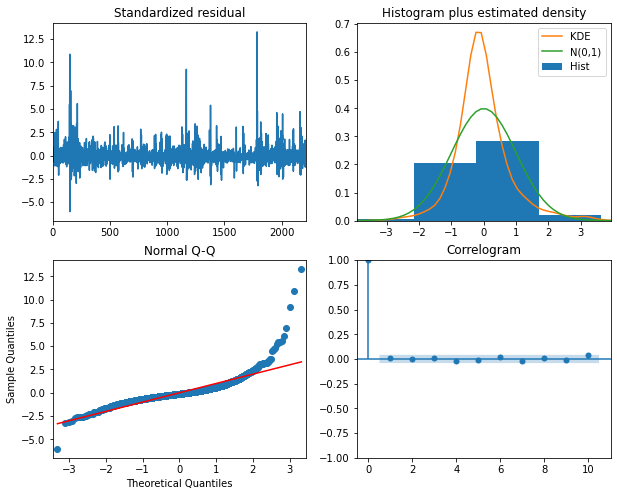

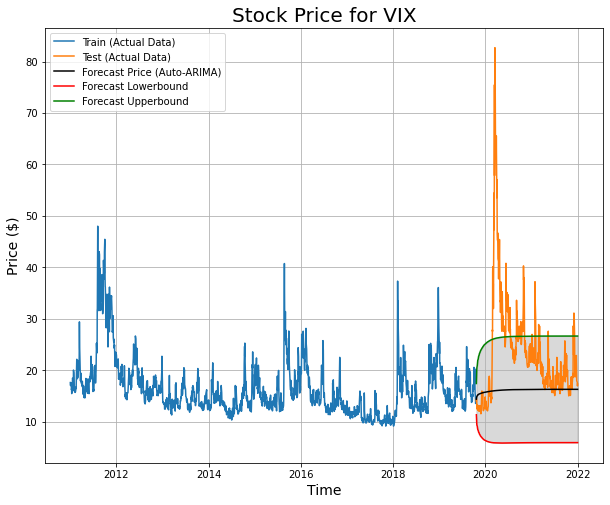

In [50]:
auto_arima_work('VIX')

- Standardized Residual: The residual errors seem to fluctuate around a mean of zero and have nearly uniform variance.
- The Density Plot: suggets normal distribution with mean of zero. 
- Normal Q-Q Plot: The dots should fall along the red line. Anything deviating from the red line significantly implies skewed distribution. 
- Correlogram: This is ACF plot showing the residual errors that are not autocorrelated. An autocorrelation would imply an existing pattern in the residual errors that cannot be explained by the model. 

VIX is the volatility index of the market and has an usual trend of going the opposite direction of general market growth. VIX price goes down when the market is stable and growing, and goes up when the market is unstable. VIX was the ONLY one the price data was stationary at baseline, as opposed to the other stock ticker names. As seen int he above plot, the model predicts the price of VIX pretty well within the confidence interval of the forecast price, with an exception of huge spike in 2020-2021, which can be explained by the general market tumult in 2020-2021 period due to COVID-19 pandemic related market shifts and policy changes. 

## Vector Autoregression Model
VAR class assumes that the passed time series are stationary. Non-stationary or trending data can often be transformed to be stationary by first-differencing or some other method. <br>
Here, the original dataset will be investigated followed by first-differenced dataset. 

Reference: https://www.statsmodels.org/dev/vector_ar.html#var

What Is an Endogenous Variable?
An endogenous variable is a variable in a statistical model that's changed or determined by its relationship with other variables within the model. In other words, an **endogenous variable is synonymous with a dependent variable**, meaning it correlates with other factors within the system being studied. Therefore, its values may be determined by other variables.


Endogenous variables are the opposite of **exogenous variables, which are independent variables** or outside forces. Exogenous variables can have an impact on endogenous factors, however.

### Original Data - Without Differencing

#### Creating a new dataframe with adjusted closing prices only for VAR

In [51]:
# Creating a dataframe with adjusted closing prices only for VAR.
df_var = df[['Adj_Close_AAPL', 'Adj_Close_AMZN', 'Adj_Close_GOOG', 'Adj_Close_MSFT', 'Adj_Close_QQQ', 'Adj_Close_SPY', 'Adj_Close_TSLA', 'Adj_Close_VIX']]

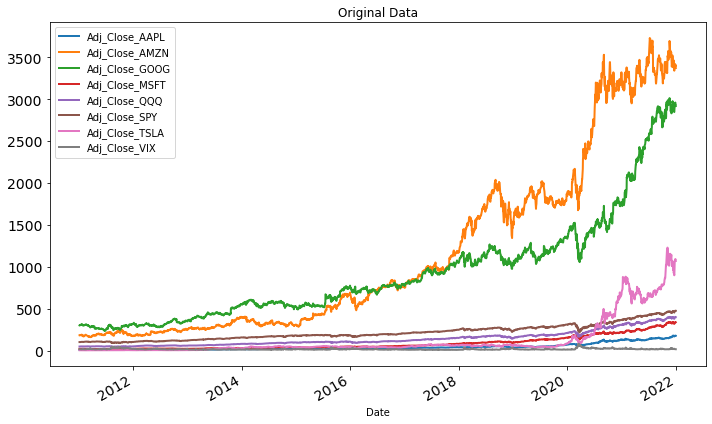

<Figure size 432x288 with 0 Axes>

In [52]:
# Original Stock Prices without differencing. Notice non-stationarity
df_var.plot(figsize=(10,6), linewidth=2, fontsize=14)
plt.title('Original Data')
plt.tight_layout()
plt.show()

# Saving figure
plt.savefig('./images/VAR_no_diff.png')

#### Train/Test sets

In [53]:
# Train/Test split, 80:20
df_var_train = df_var[: int(len(df_var) * 0.8)]
df_var_test = df_var[int(len(df_var) * 0.8): ]
print('Train shape:', df_var_train.shape), print('Test shape:', df_var_test.shape);

Train shape: (2214, 8)
Test shape: (554, 8)


#### VAR Model

In [54]:
# Instantiate VAR with train set
model_VAR = VAR(df_var_train)

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [55]:
# Compute lag order selections based on each of the available information criteria
# Setting Maxlags = 50 and constant terms.
model_VAR.select_order(50).summary()

,AIC,BIC,FPE,HQIC
0,39.13,39.15,9.840e+16,39.14
1,4.213,4.402*,67.59,4.283*
2,4.168,4.525,64.59,4.299
3,4.170,4.695,64.71,4.362
4,4.152,4.845,63.57,4.406
5,4.165,5.026,64.39,4.480
6,4.149,5.178,63.36,4.525
7,4.160,5.356,64.05,4.597
8,4.135*,5.500,62.53*,4.635
9,4.136,5.669,62.56,4.697


- AIC is lowest at lag 8
- BIC is lowest at lag 2
- FPE is lowest at lag 8
- HQIC is lowest at lag 2.

Will proceed with the lowest lag, 2.

In [56]:
# Resetting the model with the lowest lag
model_VAR = VAR(df_var_train)
# Results. Setting maxlags 2 here and it will use bic as VAR order selection.
results_VAR = model_VAR.fit(2)

# Summary of VAR
results_VAR.summary()

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 05, Feb, 2022
Time:                     15:49:49
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                    4.38150
Nobs:                     2212.00    HQIC:                   4.15900
Log likelihood:          -29431.8    FPE:                    56.3141
AIC:                      4.03094    Det(Omega_mle):         52.9685
--------------------------------------------------------------------
Results for equation Adj_Close_AAPL
                       coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------
const                    -0.362523         0.171882           -2.109           0.035
L1.Adj_Close_AAPL         0.965494         0.035559           27.152           0.000
L1.Adj_Close_AMZN        -0.002968 

In [57]:
# Obtaining the lag
lag_VAR = results_VAR.k_ar
lag_VAR

2

#### VAR Forecast

In [58]:
# Forecasting - We need the data to lag by "lag_VAR" to predict the next value. 
df_var_pred = pd.DataFrame(results_VAR.forecast(df_var_train.values[-lag_VAR: ], steps=554), index=df_var_test.index, columns=df_var_train.columns)
df_var_pred.tail()

,Adj_Close_AAPL,Adj_Close_AMZN,Adj_Close_GOOG,Adj_Close_MSFT,Adj_Close_QQQ,Adj_Close_SPY,Adj_Close_TSLA,Adj_Close_VIX
Date,,,,,,,,
2021-12-23,66.559804,2085.060069,1485.031155,146.817401,228.136418,342.793320,92.444166,12.082451
2021-12-27,66.581780,2086.219238,1485.604871,146.881522,228.215232,342.893208,92.470010,12.081002
2021-12-28,66.603781,2087.378252,1486.178397,146.945710,228.294062,342.993104,92.495815,12.079556
2021-12-29,66.625806,2088.537104,1486.751735,147.009965,228.372906,343.093009,92.521583,12.078113
2021-12-30,66.647855,2089.695792,1487.324883,147.074285,228.451766,343.192923,92.547313,12.076672


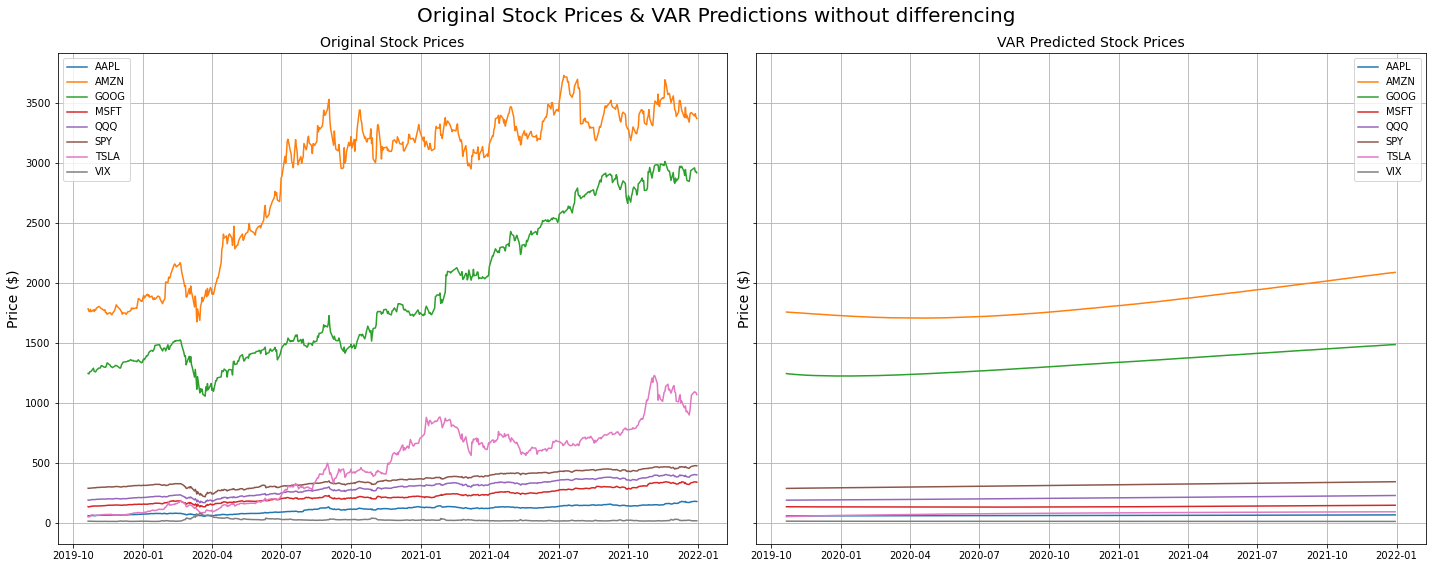

In [59]:
fig, axs = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(20,8))
fig.suptitle('Original Stock Prices & VAR Predictions without differencing', size=20)
axs[0].plot(df_var_test['Adj_Close_AAPL'], label='AAPL')
axs[0].plot(df_var_test['Adj_Close_AMZN'], label='AMZN')
axs[0].plot(df_var_test['Adj_Close_GOOG'], label='GOOG')
axs[0].plot(df_var_test['Adj_Close_MSFT'], label='MSFT')
axs[0].plot(df_var_test['Adj_Close_QQQ'], label='QQQ')
axs[0].plot(df_var_test['Adj_Close_SPY'], label='SPY')
axs[0].plot(df_var_test['Adj_Close_TSLA'], label='TSLA')
axs[0].plot(df_var_test['Adj_Close_VIX'], label='VIX')
axs[0].set_title('Original Stock Prices', size=14)
axs[0].set_ylabel('Price ($)', size=14)
axs[0].legend()
axs[0].grid()

axs[1].plot(df_var_pred['Adj_Close_AAPL'], label='AAPL')
axs[1].plot(df_var_pred['Adj_Close_AMZN'], label='AMZN')
axs[1].plot(df_var_pred['Adj_Close_GOOG'], label='GOOG')
axs[1].plot(df_var_pred['Adj_Close_MSFT'], label='MSFT')
axs[1].plot(df_var_pred['Adj_Close_QQQ'], label='QQQ')
axs[1].plot(df_var_pred['Adj_Close_SPY'], label='SPY')
axs[1].plot(df_var_pred['Adj_Close_TSLA'], label='TSLA')
axs[1].plot(df_var_pred['Adj_Close_VIX'], label='VIX')
axs[1].set_title('VAR Predicted Stock Prices', size=14)
axs[1].set_ylabel('Price ($)', size=14)
axs[1].legend()
axs[1].grid()

plt.tight_layout()

# Saving tie forecast figure
plt.savefig('./images/VAR_fc_nodiff.png');

### With First-Differencing
In the above ADFuller test section, the dataset was first-differenced and stationarity was observed. VAR will be performed on the first-differenced data. 

#### Creating a new dataframe with adjusted closing prices only for VAR - First-Differenced Data

In [60]:
# Creating a dataframe with adjusted closing prices only for VAR.
df_var_diff = df_for_diff[['Adj_Close_AAPL', 'Adj_Close_AMZN', 'Adj_Close_GOOG', 'Adj_Close_MSFT', 'Adj_Close_QQQ', 'Adj_Close_SPY', 'Adj_Close_TSLA', 'Adj_Close_VIX']]

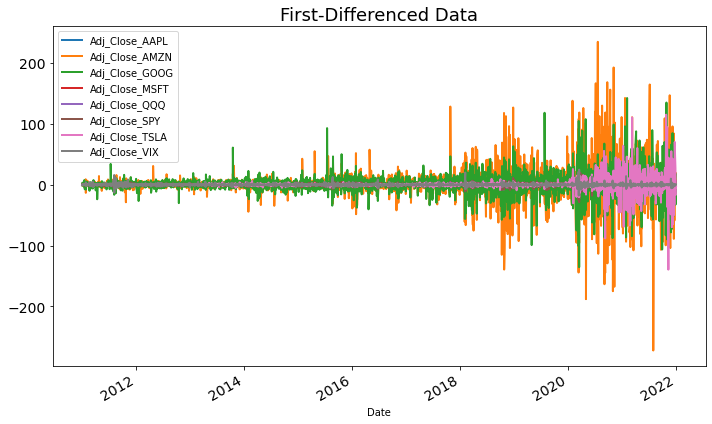

<Figure size 432x288 with 0 Axes>

In [61]:
# First-Differenced data of stock prices. Notice stationarity here.
df_var_diff.plot(figsize=(10,6), linewidth=2, fontsize=14)
plt.title('First-Differenced Data', size=18)
plt.tight_layout()
plt.show()

# Saving the figure
plt.savefig('./images/VAR_diff.png')

#### Train/Test Sets

In [62]:
# Train/Test split, 80:20
df_var_train_diff = df_var_diff[: int(len(df_var) * 0.8)]
df_var_test_diff = df_var_diff[int(len(df_var) * 0.8): ]
print('Train shape:', df_var_train_diff.shape), print('Test shape:', df_var_test_diff.shape);

Train shape: (2214, 8)
Test shape: (553, 8)


From the first-differenced data plot, we can observe that the data has become stationary. This is also confirmed via ADfuller test in the above. 

#### VAR model - First-Differenced Data

In [63]:
# Instantiate VAR
model_VAR_diff = VAR(df_var_train_diff)

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [64]:
# Compute lag order selections based on each of the available information criteria
# Setting Maxlags = 50 and constant terms.
model_VAR_diff.select_order(50).summary()

,AIC,BIC,FPE,HQIC
0,4.262,4.283*,70.98,4.270*
1,4.208,4.397,67.23,4.277
2,4.206,4.563,67.10,4.337
3,4.183,4.708,65.58,4.375
4,4.195,4.888,66.33,4.448
5,4.175,5.035,65.01,4.489
6,4.187,5.216,65.84,4.563
7,4.156*,5.352,63.80*,4.593
8,4.156,5.521,63.84,4.655
9,4.166,5.698,64.45,4.726


AIC is lowest at lag 7
BIC is lowest at lag 1
FPE is lowest at lag 7
HQIC is lowest at lag 1.
Will proceed with the lowest lag, 1.

In [65]:
# Resetting the model with the lowest lag
model_VAR_diff = VAR(df_var_train_diff)
# Results. Setting maxlags 2 here and it will use bic as VAR order selection.
results_VAR_diff = model_VAR_diff.fit(1)

# Summary of VAR
results_VAR_diff.summary()

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 05, Feb, 2022
Time:                     15:49:51
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                    4.26305
Nobs:                     2213.00    HQIC:                   4.14530
Log likelihood:          -29560.7    FPE:                    58.9995
AIC:                      4.07753    Det(Omega_mle):         57.1146
--------------------------------------------------------------------
Results for equation Adj_Close_AAPL
                       coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------
const                     0.022929         0.010040            2.284           0.022
L1.Adj_Close_AAPL        -0.017806         0.035348           -0.504           0.614
L1.Adj_Close_AMZN        -0.002875 

In [66]:
# Obtaining the lag
lag_VAR_diff = results_VAR_diff.k_ar
lag_VAR_diff

1

#### VAR Forecast - First-Differenced Data

In [67]:
# Forecasting - We need the data to lag by "lag_VAR" to predict the next value. 
df_var_pred_diff = pd.DataFrame(results_VAR_diff.forecast(df_var_train_diff.values[-lag_VAR_diff: ], steps=553), index=df_var_test_diff.index, columns=df_var_train_diff.columns)
df_var_pred_diff.tail()

,Adj_Close_AAPL,Adj_Close_AMZN,Adj_Close_GOOG,Adj_Close_MSFT,Adj_Close_QQQ,Adj_Close_SPY,Adj_Close_TSLA,Adj_Close_VIX
Date,,,,,,,,
2021-12-23,0.022115,0.723529,0.427224,0.051104,0.063771,0.084207,0.020569,-0.001516
2021-12-27,0.022115,0.723529,0.427224,0.051104,0.063771,0.084207,0.020569,-0.001516
2021-12-28,0.022115,0.723529,0.427224,0.051104,0.063771,0.084207,0.020569,-0.001516
2021-12-29,0.022115,0.723529,0.427224,0.051104,0.063771,0.084207,0.020569,-0.001516
2021-12-30,0.022115,0.723529,0.427224,0.051104,0.063771,0.084207,0.020569,-0.001516


In [68]:
# Comparing with the actual differenced values
df_var_diff.tail()

,Adj_Close_AAPL,Adj_Close_AMZN,Adj_Close_GOOG,Adj_Close_MSFT,Adj_Close_QQQ,Adj_Close_SPY,Adj_Close_TSLA,Adj_Close_VIX
Date,,,,,,,,
2021-12-23,0.639999,0.630127,3.870117,1.489990,2.970001,2.910004,58.130005,-0.670000
2021-12-27,4.050003,-27.980225,18.429932,7.760010,6.559998,6.660004,26.939941,-0.279999
2021-12-28,-1.040009,19.830078,-32.320068,-1.200012,-1.870026,-0.390015,-5.469971,-0.139999
2021-12-29,0.090012,-29.199951,1.130127,0.700012,-0.059998,0.610016,-2.280029,-0.590000
2021-12-30,-1.180008,-11.130127,-10.040039,-2.630005,-1.199982,-1.320007,-15.849976,0.379999


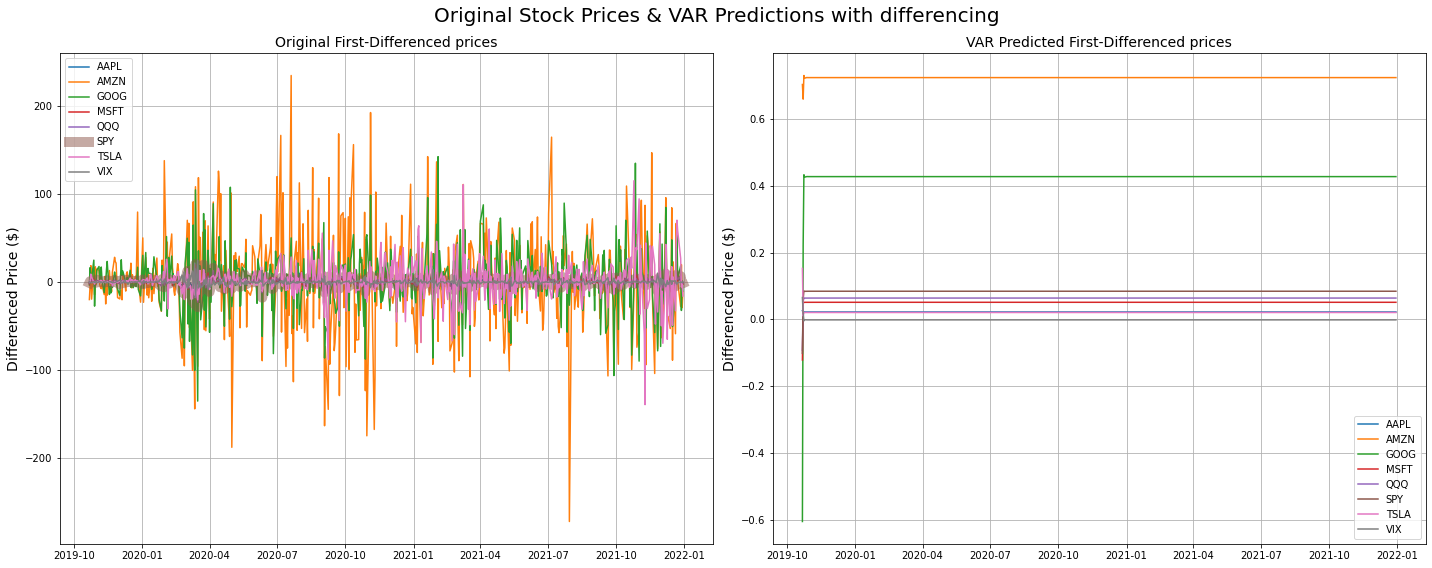

In [69]:
fig, axs = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=False, figsize=(20,8))
fig.suptitle('Original Stock Prices & VAR Predictions with differencing', size=20)
axs[0].plot(df_var_test_diff['Adj_Close_AAPL'], label='AAPL')
axs[0].plot(df_var_test_diff['Adj_Close_AMZN'], label='AMZN')
axs[0].plot(df_var_test_diff['Adj_Close_GOOG'], label='GOOG')
axs[0].plot(df_var_test_diff['Adj_Close_MSFT'], label='MSFT')
axs[0].plot(df_var_test_diff['Adj_Close_QQQ'], label='QQQ')
axs[0].plot(df_var_test_diff['Adj_Close_SPY'], label='SPY', alpha=0.5, linewidth=10)
axs[0].plot(df_var_test_diff['Adj_Close_TSLA'], label='TSLA')
axs[0].plot(df_var_test_diff['Adj_Close_VIX'], label='VIX')
axs[0].set_title('Original First-Differenced prices', size=14)
axs[0].set_ylabel('Differenced Price ($)', size=14)
axs[0].legend()
axs[0].grid()

axs[1].plot(df_var_pred_diff['Adj_Close_AAPL'], label='AAPL')
axs[1].plot(df_var_pred_diff['Adj_Close_AMZN'], label='AMZN')
axs[1].plot(df_var_pred_diff['Adj_Close_GOOG'], label='GOOG')
axs[1].plot(df_var_pred_diff['Adj_Close_MSFT'], label='MSFT')
axs[1].plot(df_var_pred_diff['Adj_Close_QQQ'], label='QQQ')
axs[1].plot(df_var_pred_diff['Adj_Close_SPY'], label='SPY')
axs[1].plot(df_var_pred_diff['Adj_Close_TSLA'], label='TSLA')
axs[1].plot(df_var_pred_diff['Adj_Close_VIX'], label='VIX')
axs[1].set_title('VAR Predicted First-Differenced prices', size=14)
axs[1].set_ylabel('Differenced Price ($)', size=14)
axs[1].legend()
axs[1].grid()

plt.tight_layout()

# Saving the figure
plt.savefig('./images/VAR_fc_diff.png');

## Long Short-Term Memory (LSTM) Model
Univariate and/or Multivariate LSTM Model based on the **adjusted closing price, volume, and daily percent change** of the stock prices. <br>

- Reference: Code inspired by "DigitalSreeni" and modified: [link to tutorial](https://www.youtube.com/watch?v=tepxdcepTbY&t=494s)

#### DataFrames for Modeling

In [70]:
# Splitting Data into Training and Test sets, 80:20 Split
df_LSTM_train = pd.DataFrame(df_tts[0:int(len(df_tts)*0.8)])
df_LSTM_test = pd.DataFrame(df_tts[int(len(df_tts)*0.8):int(len(df_tts))])
print('Train:', df_LSTM_train.shape), print('Test:', df_LSTM_test.shape);

Train: (2214, 23)
Test: (554, 23)


In [71]:
# Train/Test Indices
train_dates = df_LSTM_train.index
test_dates = df_LSTM_test.index

#### AAPL - Apple

In [72]:
# Setting train/test dataframe for AAPL
df_LSTM_train_AAPL = df_LSTM_train[['Adj_Close_AAPL', 'Volume_AAPL', 'AAPL_daily_pct_change']]
df_LSTM_test_AAPL = df_LSTM_test[['Adj_Close_AAPL', 'Volume_AAPL', 'AAPL_daily_pct_change']]

# Instantiate MinMaxScaler
scaler = MinMaxScaler()

# Fit & transform the training data
df_LSTM_train_scaled_AAPL = scaler.fit_transform(df_LSTM_train_AAPL)

# Setting X & Y train
X_train_AAPL = []
y_train_AAPL = []

# Number of days to be predicted 
days_future = 1
# Number of days in the past to be used for future prediction. Picking 5 trading days for the previous week (Rolling 5 days = 1 trading week)
days_past = 5

for i in range(days_past, len(df_LSTM_train_scaled_AAPL) - days_future + 1):
    X_train_AAPL.append(df_LSTM_train_scaled_AAPL[i - days_past:i, 0 : df_LSTM_train_AAPL.shape[1]])
    y_train_AAPL.append(df_LSTM_train_scaled_AAPL[i + days_future - 1 : i + days_future, 0])
    
# Converting X & y train into array
X_train_AAPL, y_train_AAPL = np.array(X_train_AAPL), np.array(y_train_AAPL)
# Printing shape of X & y train after converting to array.
print('Notice the difference in the number of rows (holding period 5)')
print('X_train_AAPL:', X_train_AAPL.shape), print('y_train_AAPL:', y_train_AAPL.shape);

Notice the difference in the number of rows (holding period 5)
X_train_AAPL: (2209, 5, 3)
y_train_AAPL: (2209, 1)


In [73]:
# Instantiating the model
model_AAPL = Sequential()

# First Layer. return_sequences set to true because we want this LSTM to return a sequence for the next LSTM. We have stacked LSTM. 
model_AAPL.add(LSTM(units=50, activation='relu', return_sequences=True, input_shape=(X_train_AAPL.shape[1], X_train_AAPL.shape[2])))
model_AAPL.add(Dropout(0.2))

# Second layer
model_AAPL.add(LSTM(units=60, activation='relu', return_sequences=True))
model_AAPL.add(Dropout(0.3))

# Third layer
model_AAPL.add(LSTM(units=80, activation='relu', return_sequences=True))
model_AAPL.add(Dropout(0.4))

# Fourth layer
model_AAPL.add(LSTM(units=120, activation='relu'))
model_AAPL.add(Dropout(0.5))

# Dense Layer - to connect all the layers
model_AAPL.add(Dense(y_train_AAPL.shape[1]))

# Model Summary
print(model_AAPL.summary())

# Compiling the models. Keeping the loss as MSE for Time-Series analysis
model_AAPL.compile(optimizer='adam', loss='mean_squared_error')

# Adding EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')
# Fitting the model on training data with early stopping
# Using 10% of the training data as validation set.
history_AAPL = model_AAPL.fit(X_train_AAPL, y_train_AAPL, validation_split=0.1, epochs=50, callbacks=[early_stop])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 50)             10800     
                                                                 
 dropout (Dropout)           (None, 5, 50)             0         
                                                                 
 lstm_1 (LSTM)               (None, 5, 60)             26640     
                                                                 
 dropout_1 (Dropout)         (None, 5, 60)             0         
                                                                 
 lstm_2 (LSTM)               (None, 5, 80)             45120     
                                                                 
 dropout_2 (Dropout)         (None, 5, 80)             0         
                                                                 
 lstm_3 (LSTM)               (None, 120)               9

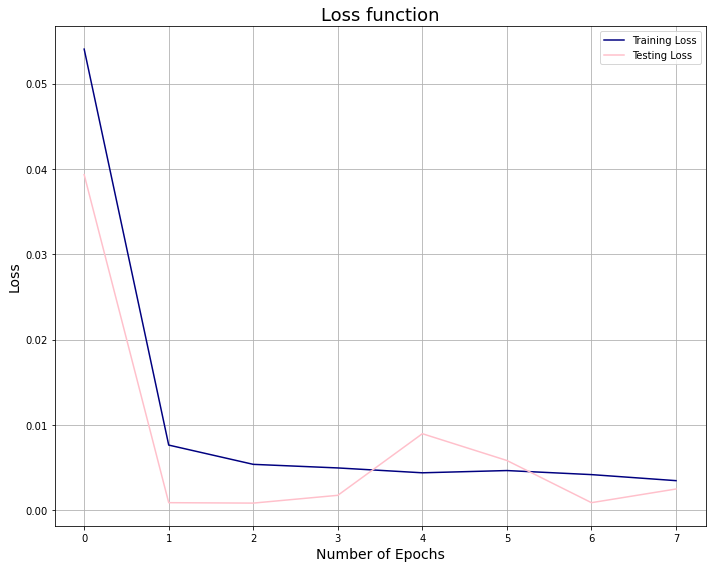

<Figure size 432x288 with 0 Axes>

In [74]:
# Plotting Loss function
train_loss_AAPL = history_AAPL.history['loss']
test_loss_AAPL = history_AAPL.history['val_loss']

plt.figure(figsize=(10,8))
plt.plot(train_loss_AAPL, label='Training Loss', color='navy')
plt.plot(test_loss_AAPL, label='Testing Loss', color='pink')
plt.legend()

plt.title('Loss function', size=18)
plt.xlabel('Number of Epochs', size=14)
plt.ylabel('Loss', size=14)
plt.grid()
plt.tight_layout()
plt.show()

# Saving the figure
plt.savefig('./images/LSTM_loss_fx_AAPL.png');

From the above plot, it seems the loss is stabilized around 10 epoch.

In [75]:
# Forecasting
# Currently, test set has 554 days to the end of Dec. 2021. Would like to see more into Jan. 2022.
days_future = 837
# Starting with the last day in the training dataset and above-defined days into the future. 
forecast_dates_AAPL = pd.date_range(list(train_dates)[-1], periods=days_future, freq='1d').tolist()
# Forecast
forecast_AAPL = model_AAPL.predict(X_train_AAPL[-days_future: ])

# Inverse transform to obtain the interpretable price data from the forecast.
# Consider this one is a multivariate model, need to make sure the number of columns match between input and output.
y_pred_AAPL = scaler.inverse_transform(np.repeat(forecast_AAPL, df_LSTM_train_AAPL.shape[1], axis=-1))[:, 0]

# Converting timestamp to date
forecast_dates = []
for i in forecast_dates_AAPL:
    forecast_dates.append(i.date())

df_forecast_AAPL = pd.DataFrame({'Date': np.array(forecast_dates), 'Adj_Close_AAPL': y_pred_AAPL})
df_forecast_AAPL['Date'] = pd.to_datetime(df_forecast_AAPL['Date'])
df_forecast_AAPL.set_index('Date', inplace=True)

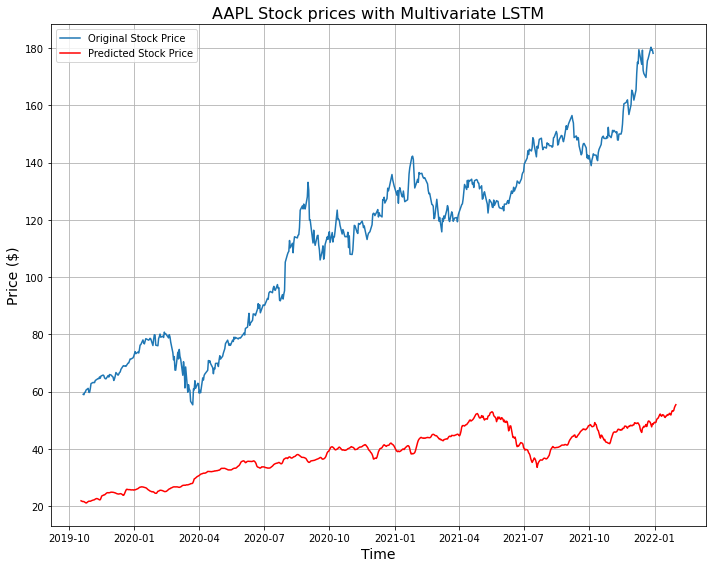

<Figure size 432x288 with 0 Axes>

In [76]:
# Plotting 
plt.figure(figsize=(10,8))
plt.plot(df_LSTM_test_AAPL.index, df_LSTM_test_AAPL['Adj_Close_AAPL'], label='Original Stock Price')
plt.plot(df_forecast_AAPL.index, df_forecast_AAPL['Adj_Close_AAPL'], label='Predicted Stock Price', color='r')

plt.title('AAPL Stock prices with Multivariate LSTM', size=16)
plt.xlabel('Time', size=14)
plt.ylabel('Price ($)', size=14)
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

# Saving the figure
plt.savefig('./images/LSTM_fc_AAPL.png');

#### AMZN - Amazon

In [77]:
# Setting train/test dataframe for AMZN
df_LSTM_train_AMZN = df_LSTM_train[['Adj_Close_AMZN', 'Volume_AMZN', 'AMZN_daily_pct_change']]
df_LSTM_test_AMZN = df_LSTM_test[['Adj_Close_AMZN', 'Volume_AMZN', 'AMZN_daily_pct_change']]

# Instantiate MinMaxScaler
scaler = MinMaxScaler()

# Fit & transform the training data
df_LSTM_train_scaled_AMZN = scaler.fit_transform(df_LSTM_train_AMZN)

# Setting X & Y train
X_train_AMZN = []
y_train_AMZN = []

# Number of days to be predicted 
days_future = 1
# Number of days in the past to be used for future prediction. Picking 5 trading days for the previous week (Rolling 5 days = 1 trading week)
days_past = 5

for i in range(days_past, len(df_LSTM_train_scaled_AMZN) - days_future + 1):
    X_train_AMZN.append(df_LSTM_train_scaled_AMZN[i - days_past:i, 0 : df_LSTM_train_AMZN.shape[1]])
    y_train_AMZN.append(df_LSTM_train_scaled_AMZN[i + days_future - 1 : i + days_future, 0])
    
# Converting X & y train into array
X_train_AMZN, y_train_AMZN = np.array(X_train_AMZN), np.array(y_train_AMZN)
# Printing shape of X & y train after converting to array.
print('Notice the difference in the number of rows (holding period 5)')
print('X_train_AMZN:', X_train_AMZN.shape), print('y_train_AMZN:', y_train_AMZN.shape);

Notice the difference in the number of rows (holding period 5)
X_train_AMZN: (2209, 5, 3)
y_train_AMZN: (2209, 1)


In [78]:
# Instantiating the model
model_AMZN = Sequential()

# First Layer. return_sequences set to true because we want this LSTM to return a sequence for the next LSTM. We have stacked LSTM. 
model_AMZN.add(LSTM(units=50, activation='relu', return_sequences=True, input_shape=(X_train_AMZN.shape[1], X_train_AMZN.shape[2])))
model_AMZN.add(Dropout(0.2))

# Second layer
model_AMZN.add(LSTM(units=60, activation='relu', return_sequences=True))
model_AMZN.add(Dropout(0.3))

# Third layer
model_AMZN.add(LSTM(units=80, activation='relu', return_sequences=True))
model_AMZN.add(Dropout(0.4))

# Fourth layer
model_AMZN.add(LSTM(units=120, activation='relu'))
model_AMZN.add(Dropout(0.5))

# Dense Layer - to connect all the layers
model_AMZN.add(Dense(y_train_AMZN.shape[1]))

# Model Summary
print(model_AMZN.summary())

# Compiling the models. Keeping the loss as MSE for Time-Series analysis
model_AMZN.compile(optimizer='adam', loss='mean_squared_error')

# Adding EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')
# Fitting the model on training data with early stopping
# Using 10% of the training data as validation set.
history_AMZN = model_AMZN.fit(X_train_AMZN, y_train_AMZN, validation_split=0.1, epochs=50, callbacks=[early_stop])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 5, 50)             10800     
                                                                 
 dropout_4 (Dropout)         (None, 5, 50)             0         
                                                                 
 lstm_5 (LSTM)               (None, 5, 60)             26640     
                                                                 
 dropout_5 (Dropout)         (None, 5, 60)             0         
                                                                 
 lstm_6 (LSTM)               (None, 5, 80)             45120     
                                                                 
 dropout_6 (Dropout)         (None, 5, 80)             0         
                                                                 
 lstm_7 (LSTM)               (None, 120)              

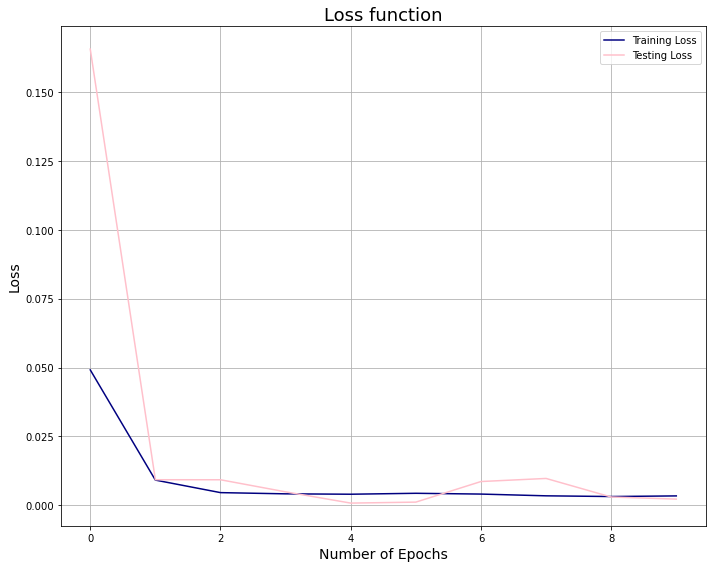

<Figure size 432x288 with 0 Axes>

In [79]:
# Plotting Loss function
train_loss_AMZN = history_AMZN.history['loss']
test_loss_AMZN = history_AMZN.history['val_loss']

plt.figure(figsize=(10,8))
plt.plot(train_loss_AMZN, label='Training Loss', color='navy')
plt.plot(test_loss_AMZN, label='Testing Loss', color='pink')
plt.legend()

plt.title('Loss function', size=18)
plt.xlabel('Number of Epochs', size=14)
plt.ylabel('Loss', size=14)
plt.grid()
plt.tight_layout()
plt.show()

# Saving the figure
plt.savefig('./images/LSTM_loss_fx_AMZN.png');

In [80]:
# Forecasting
# Currently, test set has 554 days to the end of Dec. 2021. Would like to see more into Jan. 2022.
days_future = 837
# Starting with the last day in the training dataset and above-defined days into the future. 
forecast_dates_AMZN = pd.date_range(list(train_dates)[-1], periods=days_future, freq='1d').tolist()
# Forecast
forecast_AMZN = model_AMZN.predict(X_train_AMZN[-days_future: ])

# Inverse transform to obtain the interpretable price data from the forecast.
# Consider this one is a multivariate model, need to make sure the number of columns match between input and output.
y_pred_AMZN = scaler.inverse_transform(np.repeat(forecast_AMZN, df_LSTM_train_AMZN.shape[1], axis=-1))[:, 0]

# Converting timestamp to date
forecast_dates = []
for i in forecast_dates_AMZN:
    forecast_dates.append(i.date())

df_forecast_AMZN = pd.DataFrame({'Date': np.array(forecast_dates), 'Adj_Close_AMZN': y_pred_AMZN})
df_forecast_AMZN['Date'] = pd.to_datetime(df_forecast_AMZN['Date'])
df_forecast_AMZN.set_index('Date', inplace=True)

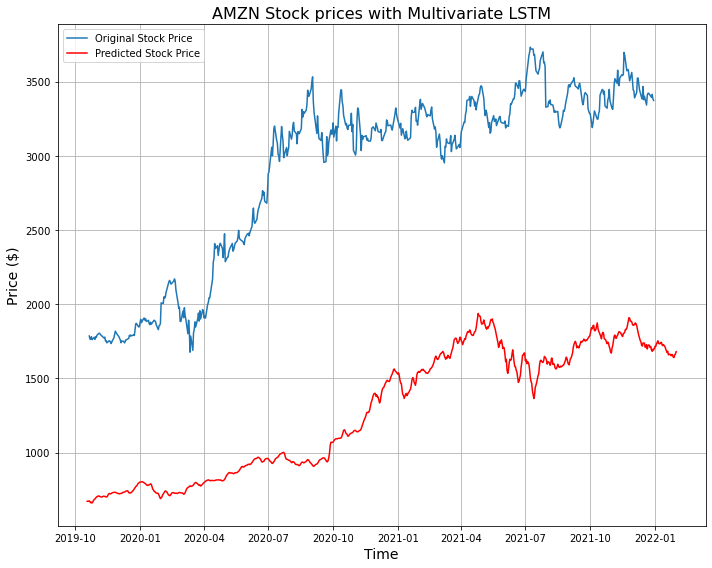

<Figure size 432x288 with 0 Axes>

In [81]:
# Plotting 
plt.figure(figsize=(10,8))
plt.plot(df_LSTM_test_AMZN.index, df_LSTM_test_AMZN['Adj_Close_AMZN'], label='Original Stock Price')
plt.plot(df_forecast_AMZN.index, df_forecast_AMZN['Adj_Close_AMZN'], label='Predicted Stock Price', color='r')

plt.title('AMZN Stock prices with Multivariate LSTM', size=16)
plt.xlabel('Time', size=14)
plt.ylabel('Price ($)', size=14)
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

# Saving the figure
plt.savefig('./images/LSTM_fc_AMZN.png');

#### GOOG - Alphabet, Inc. (Google)

In [82]:
# Setting train/test dataframe for GOOG
df_LSTM_train_GOOG = df_LSTM_train[['Adj_Close_GOOG', 'Volume_GOOG', 'GOOG_daily_pct_change']]
df_LSTM_test_GOOG = df_LSTM_test[['Adj_Close_GOOG', 'Volume_GOOG', 'GOOG_daily_pct_change']]

# Instantiate MinMaxScaler
scaler = MinMaxScaler()

# Fit & transform the training data
df_LSTM_train_scaled_GOOG = scaler.fit_transform(df_LSTM_train_GOOG)

# Setting X & Y train
X_train_GOOG = []
y_train_GOOG = []

# Number of days to be predicted 
days_future = 1
# Number of days in the past to be used for future prediction. Picking 5 trading days for the previous week (Rolling 5 days = 1 trading week)
days_past = 5

for i in range(days_past, len(df_LSTM_train_scaled_GOOG) - days_future + 1):
    X_train_GOOG.append(df_LSTM_train_scaled_GOOG[i - days_past:i, 0 : df_LSTM_train_GOOG.shape[1]])
    y_train_GOOG.append(df_LSTM_train_scaled_GOOG[i + days_future - 1 : i + days_future, 0])
    
# Converting X & y train into array
X_train_GOOG, y_train_GOOG = np.array(X_train_GOOG), np.array(y_train_GOOG)
# Printing shape of X & y train after converting to array.
print('Notice the difference in the number of rows (holding period 5)')
print('X_train_GOOG:', X_train_GOOG.shape), print('y_train_GOOG:', y_train_GOOG.shape);

Notice the difference in the number of rows (holding period 5)
X_train_GOOG: (2209, 5, 3)
y_train_GOOG: (2209, 1)


In [83]:
# Instantiating the model
model_GOOG = Sequential()

# First Layer. return_sequences set to true because we want this LSTM to return a sequence for the next LSTM. We have stacked LSTM. 
model_GOOG.add(LSTM(units=50, activation='relu', return_sequences=True, input_shape=(X_train_GOOG.shape[1], X_train_GOOG.shape[2])))
model_GOOG.add(Dropout(0.2))

# Second layer
model_GOOG.add(LSTM(units=60, activation='relu', return_sequences=True))
model_GOOG.add(Dropout(0.3))

# Third layer
model_GOOG.add(LSTM(units=80, activation='relu', return_sequences=True))
model_GOOG.add(Dropout(0.4))

# Fourth layer
model_GOOG.add(LSTM(units=120, activation='relu'))
model_GOOG.add(Dropout(0.5))

# Dense Layer - to connect all the layers
model_GOOG.add(Dense(y_train_GOOG.shape[1]))

# Model Summary
print(model_GOOG.summary())

# Compiling the models. Keeping the loss as MSE for Time-Series analysis
model_GOOG.compile(optimizer='adam', loss='mean_squared_error')

# Adding EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')
# Fitting the model on training data with early stopping
# Using 10% of the training data as validation set.
history_GOOG = model_GOOG.fit(X_train_GOOG, y_train_GOOG, validation_split=0.1, epochs=50, callbacks=[early_stop])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 5, 50)             10800     
                                                                 
 dropout_8 (Dropout)         (None, 5, 50)             0         
                                                                 
 lstm_9 (LSTM)               (None, 5, 60)             26640     
                                                                 
 dropout_9 (Dropout)         (None, 5, 60)             0         
                                                                 
 lstm_10 (LSTM)              (None, 5, 80)             45120     
                                                                 
 dropout_10 (Dropout)        (None, 5, 80)             0         
                                                                 
 lstm_11 (LSTM)              (None, 120)              

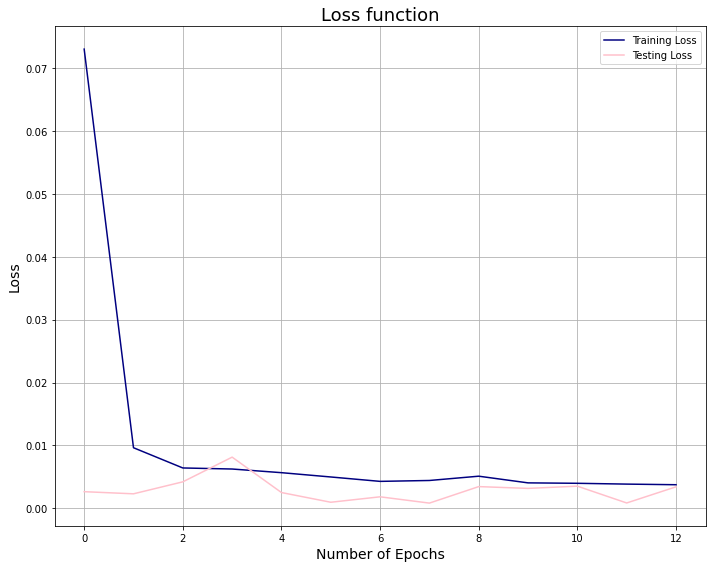

<Figure size 432x288 with 0 Axes>

In [84]:
# Plotting Loss function
train_loss_GOOG = history_GOOG.history['loss']
test_loss_GOOG = history_GOOG.history['val_loss']

plt.figure(figsize=(10,8))
plt.plot(train_loss_GOOG, label='Training Loss', color='navy')
plt.plot(test_loss_GOOG, label='Testing Loss', color='pink')
plt.legend()

plt.title('Loss function', size=18)
plt.xlabel('Number of Epochs', size=14)
plt.ylabel('Loss', size=14)
plt.grid()
plt.tight_layout()
plt.show()

# Saving the figure
plt.savefig('./images/LSTM_loss_fx_GOOG.png');

In [85]:
# Forecasting
# Currently, test set has 554 days to the end of Dec. 2021. Would like to see more into Jan. 2022.
days_future = 837
# Starting with the last day in the training dataset and above-defined days into the future. 
forecast_dates_GOOG = pd.date_range(list(train_dates)[-1], periods=days_future, freq='1d').tolist()
# Forecast
forecast_GOOG = model_GOOG.predict(X_train_GOOG[-days_future: ])

# Inverse transform to obtain the interpretable price data from the forecast.
# Consider this one is a multivariate model, need to make sure the number of columns match between input and output.
y_pred_GOOG = scaler.inverse_transform(np.repeat(forecast_GOOG, df_LSTM_train_GOOG.shape[1], axis=-1))[:, 0]

# Converting timestamp to date
forecast_dates = []
for i in forecast_dates_GOOG:
    forecast_dates.append(i.date())

df_forecast_GOOG = pd.DataFrame({'Date': np.array(forecast_dates), 'Adj_Close_GOOG': y_pred_GOOG})
df_forecast_GOOG['Date'] = pd.to_datetime(df_forecast_GOOG['Date'])
df_forecast_GOOG.set_index('Date', inplace=True)

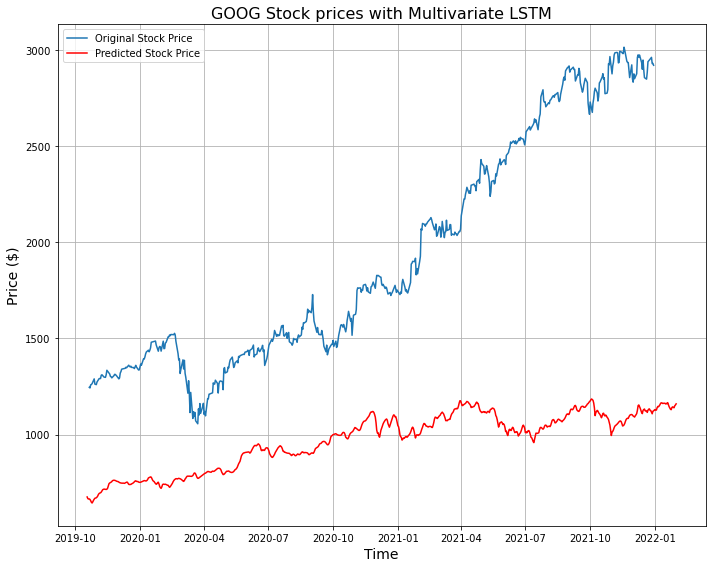

<Figure size 432x288 with 0 Axes>

In [86]:
# Plotting 
plt.figure(figsize=(10,8))
plt.plot(df_LSTM_test_GOOG.index, df_LSTM_test_GOOG['Adj_Close_GOOG'], label='Original Stock Price')
plt.plot(df_forecast_GOOG.index, df_forecast_GOOG['Adj_Close_GOOG'], label='Predicted Stock Price', color='r')

plt.title('GOOG Stock prices with Multivariate LSTM', size=16)
plt.xlabel('Time', size=14)
plt.ylabel('Price ($)', size=14)
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()
# Saving the figure
plt.savefig('./images/LSTM_fc_GOOG.png');

#### MSFT - Microsoft

In [87]:
# Setting train/test dataframe for MSFT
df_LSTM_train_MSFT = df_LSTM_train[['Adj_Close_MSFT', 'Volume_MSFT', 'MSFT_daily_pct_change']]
df_LSTM_test_MSFT = df_LSTM_test[['Adj_Close_MSFT', 'Volume_MSFT', 'MSFT_daily_pct_change']]

# Instantiate MinMaxScaler
scaler = MinMaxScaler()

# Fit & transform the training data
df_LSTM_train_scaled_MSFT = scaler.fit_transform(df_LSTM_train_MSFT)

# Setting X & Y train
X_train_MSFT = []
y_train_MSFT = []

# Number of days to be predicted 
days_future = 1
# Number of days in the past to be used for future prediction. Picking 5 trading days for the previous week (Rolling 5 days = 1 trading week)
days_past = 5

for i in range(days_past, len(df_LSTM_train_scaled_MSFT) - days_future + 1):
    X_train_MSFT.append(df_LSTM_train_scaled_MSFT[i - days_past:i, 0 : df_LSTM_train_MSFT.shape[1]])
    y_train_MSFT.append(df_LSTM_train_scaled_MSFT[i + days_future - 1 : i + days_future, 0])
    
# Converting X & y train into array
X_train_MSFT, y_train_MSFT = np.array(X_train_MSFT), np.array(y_train_MSFT)
# Printing shape of X & y train after converting to array.
print('Notice the difference in the number of rows (holding period 5)')
print('X_train_MSFT:', X_train_MSFT.shape), print('y_train_MSFT:', y_train_MSFT.shape);

Notice the difference in the number of rows (holding period 5)
X_train_MSFT: (2209, 5, 3)
y_train_MSFT: (2209, 1)


In [88]:
# Instantiating the model
model_MSFT = Sequential()

# First Layer. return_sequences set to true because we want this LSTM to return a sequence for the next LSTM. We have stacked LSTM. 
model_MSFT.add(LSTM(units=50, activation='relu', return_sequences=True, input_shape=(X_train_MSFT.shape[1], X_train_MSFT.shape[2])))
model_MSFT.add(Dropout(0.2))

# Second layer
model_MSFT.add(LSTM(units=60, activation='relu', return_sequences=True))
model_MSFT.add(Dropout(0.3))

# Third layer
model_MSFT.add(LSTM(units=80, activation='relu', return_sequences=True))
model_MSFT.add(Dropout(0.4))

# Fourth layer
model_MSFT.add(LSTM(units=120, activation='relu'))
model_MSFT.add(Dropout(0.5))

# Dense Layer - to connect all the layers
model_MSFT.add(Dense(y_train_MSFT.shape[1]))

# Model Summary
print(model_MSFT.summary())

# Compiling the models. Keeping the loss as MSE for Time-Series analysis
model_MSFT.compile(optimizer='adam', loss='mean_squared_error')

# Adding EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')
# Fitting the model on training data with early stopping
# Using 10% of the training data as validation set.
history_MSFT = model_MSFT.fit(X_train_MSFT, y_train_MSFT, validation_split=0.1, epochs=50, callbacks=[early_stop])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 5, 50)             10800     
                                                                 
 dropout_12 (Dropout)        (None, 5, 50)             0         
                                                                 
 lstm_13 (LSTM)              (None, 5, 60)             26640     
                                                                 
 dropout_13 (Dropout)        (None, 5, 60)             0         
                                                                 
 lstm_14 (LSTM)              (None, 5, 80)             45120     
                                                                 
 dropout_14 (Dropout)        (None, 5, 80)             0         
                                                                 
 lstm_15 (LSTM)              (None, 120)              

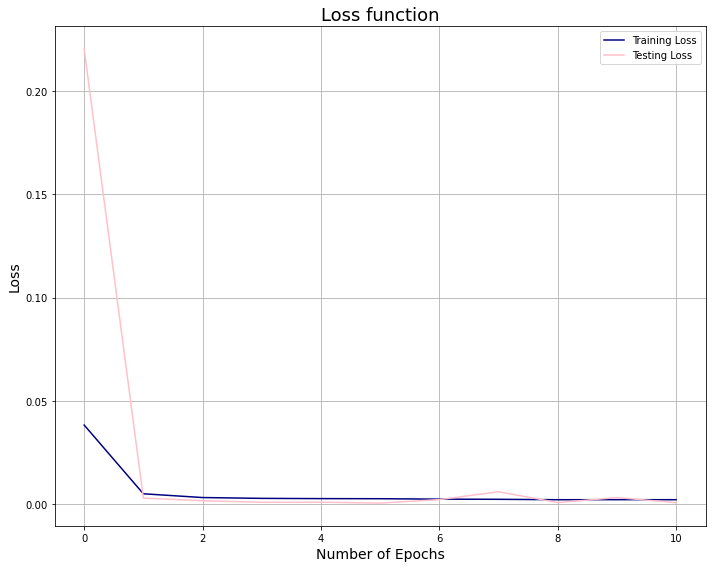

<Figure size 432x288 with 0 Axes>

In [89]:
# Plotting Loss function
train_loss_MSFT = history_MSFT.history['loss']
test_loss_MSFT = history_MSFT.history['val_loss']

plt.figure(figsize=(10,8))
plt.plot(train_loss_MSFT, label='Training Loss', color='navy')
plt.plot(test_loss_MSFT, label='Testing Loss', color='pink')
plt.legend()

plt.title('Loss function', size=18)
plt.xlabel('Number of Epochs', size=14)
plt.ylabel('Loss', size=14)
plt.grid()
plt.tight_layout()
plt.show()

# Saving the figure
plt.savefig('./images/LSTM_loss_fx_MSFT.png');

In [90]:
# Forecasting
# Currently, test set has 554 days to the end of Dec. 2021. Would like to see more into Jan. 2022.
days_future = 837
# Starting with the last day in the training dataset and above-defined days into the future. 
forecast_dates_MSFT = pd.date_range(list(train_dates)[-1], periods=days_future, freq='1d').tolist()
# Forecast
forecast_MSFT = model_MSFT.predict(X_train_MSFT[-days_future: ])

# Inverse transform to obtain the interpretable price data from the forecast.
# Consider this one is a multivariate model, need to make sure the number of columns match between input and output.
y_pred_MSFT = scaler.inverse_transform(np.repeat(forecast_MSFT, df_LSTM_train_MSFT.shape[1], axis=-1))[:, 0]

# Converting timestamp to date
forecast_dates = []
for i in forecast_dates_MSFT:
    forecast_dates.append(i.date())

df_forecast_MSFT = pd.DataFrame({'Date': np.array(forecast_dates), 'Adj_Close_MSFT': y_pred_MSFT})
df_forecast_MSFT['Date'] = pd.to_datetime(df_forecast_MSFT['Date'])
df_forecast_MSFT.set_index('Date', inplace=True)

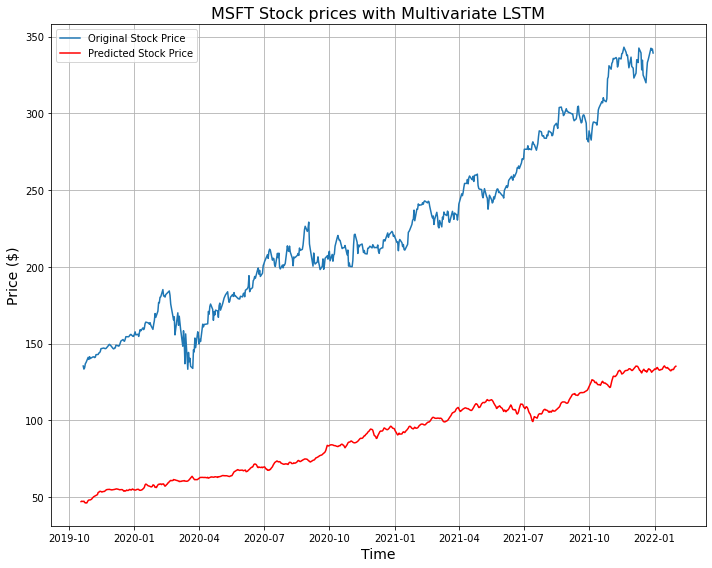

<Figure size 432x288 with 0 Axes>

In [91]:
# Plotting 
plt.figure(figsize=(10,8))
plt.plot(df_LSTM_test_MSFT.index, df_LSTM_test_MSFT['Adj_Close_MSFT'], label='Original Stock Price')
plt.plot(df_forecast_MSFT.index, df_forecast_MSFT['Adj_Close_MSFT'], label='Predicted Stock Price', color='r')

plt.title('MSFT Stock prices with Multivariate LSTM', size=16)
plt.xlabel('Time', size=14)
plt.ylabel('Price ($)', size=14)
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

# Saving the figure
plt.savefig('./images/LSTM_fc_MSFT.png');

#### QQQ - Nasdaq Index

In [92]:
# Setting train/test dataframe for QQQ
df_LSTM_train_QQQ = df_LSTM_train[['Adj_Close_QQQ', 'Volume_QQQ', 'QQQ_daily_pct_change']]
df_LSTM_test_QQQ = df_LSTM_test[['Adj_Close_QQQ', 'Volume_QQQ', 'QQQ_daily_pct_change']]

# Instantiate MinMaxScaler
scaler = MinMaxScaler()

# Fit & transform the training data
df_LSTM_train_scaled_QQQ = scaler.fit_transform(df_LSTM_train_QQQ)

# Setting X & Y train
X_train_QQQ = []
y_train_QQQ = []

# Number of days to be predicted 
days_future = 1
# Number of days in the past to be used for future prediction. Picking 5 trading days for the previous week (Rolling 5 days = 1 trading week)
days_past = 5

for i in range(days_past, len(df_LSTM_train_scaled_QQQ) - days_future + 1):
    X_train_QQQ.append(df_LSTM_train_scaled_QQQ[i - days_past:i, 0 : df_LSTM_train_QQQ.shape[1]])
    y_train_QQQ.append(df_LSTM_train_scaled_QQQ[i + days_future - 1 : i + days_future, 0])
    
# Converting X & y train into array
X_train_QQQ, y_train_QQQ = np.array(X_train_QQQ), np.array(y_train_QQQ)
# Printing shape of X & y train after converting to array.
print('Notice the difference in the number of rows (holding period 5)')
print('X_train_QQQ:', X_train_QQQ.shape), print('y_train_QQQ:', y_train_QQQ.shape);

Notice the difference in the number of rows (holding period 5)
X_train_QQQ: (2209, 5, 3)
y_train_QQQ: (2209, 1)


In [93]:
# Instantiating the model
model_QQQ = Sequential()

# First Layer. return_sequences set to true because we want this LSTM to return a sequence for the next LSTM. We have stacked LSTM. 
model_QQQ.add(LSTM(units=50, activation='relu', return_sequences=True, input_shape=(X_train_QQQ.shape[1], X_train_QQQ.shape[2])))
model_QQQ.add(Dropout(0.2))

# Second layer
model_QQQ.add(LSTM(units=60, activation='relu', return_sequences=True))
model_QQQ.add(Dropout(0.3))

# Third layer
model_QQQ.add(LSTM(units=80, activation='relu', return_sequences=True))
model_QQQ.add(Dropout(0.4))

# Fourth layer
model_QQQ.add(LSTM(units=120, activation='relu'))
model_QQQ.add(Dropout(0.5))

# Dense Layer - to connect all the layers
model_QQQ.add(Dense(y_train_QQQ.shape[1]))

# Model Summary
print(model_QQQ.summary())

# Compiling the models. Keeping the loss as MSE for Time-Series analysis
model_QQQ.compile(optimizer='adam', loss='mean_squared_error')

# Adding EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')
# Fitting the model on training data with early stopping
# Using 10% of the training data as validation set.
history_QQQ = model_QQQ.fit(X_train_QQQ, y_train_QQQ, validation_split=0.1, epochs=50, callbacks=[early_stop])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 5, 50)             10800     
                                                                 
 dropout_16 (Dropout)        (None, 5, 50)             0         
                                                                 
 lstm_17 (LSTM)              (None, 5, 60)             26640     
                                                                 
 dropout_17 (Dropout)        (None, 5, 60)             0         
                                                                 
 lstm_18 (LSTM)              (None, 5, 80)             45120     
                                                                 
 dropout_18 (Dropout)        (None, 5, 80)             0         
                                                                 
 lstm_19 (LSTM)              (None, 120)              

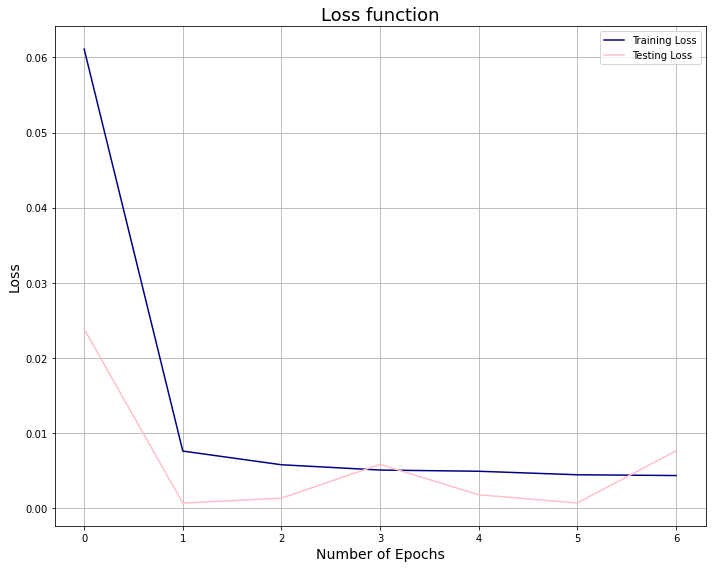

<Figure size 432x288 with 0 Axes>

In [94]:
# Plotting Loss function
train_loss_QQQ = history_QQQ.history['loss']
test_loss_QQQ = history_QQQ.history['val_loss']

plt.figure(figsize=(10,8))
plt.plot(train_loss_QQQ, label='Training Loss', color='navy')
plt.plot(test_loss_QQQ, label='Testing Loss', color='pink')
plt.legend()

plt.title('Loss function', size=18)
plt.xlabel('Number of Epochs', size=14)
plt.ylabel('Loss', size=14)
plt.grid()
plt.tight_layout()
plt.show()

# Saving the figure
plt.savefig('./images/LSTM_loss_fx_QQQ.png');

In [95]:
# Forecasting
# Currently, test set has 554 days to the end of Dec. 2021. Would like to see more into Jan. 2022.
days_future = 837
# Starting with the last day in the training dataset and above-defined days into the future. 
forecast_dates_QQQ = pd.date_range(list(train_dates)[-1], periods=days_future, freq='1d').tolist()
# Forecast
forecast_QQQ = model_QQQ.predict(X_train_QQQ[-days_future: ])

# Inverse transform to obtain the interpretable price data from the forecast.
# Consider this one is a multivariate model, need to make sure the number of columns match between input and output.
y_pred_QQQ = scaler.inverse_transform(np.repeat(forecast_QQQ, df_LSTM_train_QQQ.shape[1], axis=-1))[:, 0]

# Converting timestamp to date
forecast_dates = []
for i in forecast_dates_QQQ:
    forecast_dates.append(i.date())

df_forecast_QQQ = pd.DataFrame({'Date': np.array(forecast_dates), 'Adj_Close_QQQ': y_pred_QQQ})
df_forecast_QQQ['Date'] = pd.to_datetime(df_forecast_QQQ['Date'])
df_forecast_QQQ.set_index('Date', inplace=True)

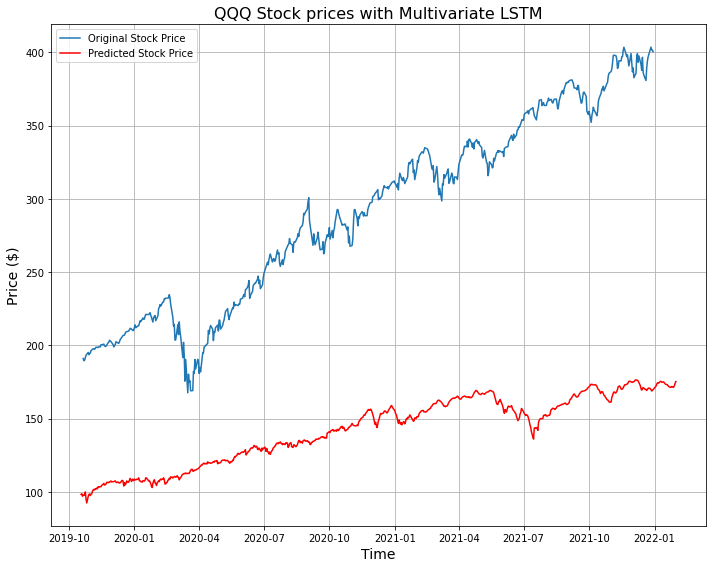

<Figure size 432x288 with 0 Axes>

In [96]:
# Plotting 
plt.figure(figsize=(10,8))
plt.plot(df_LSTM_test_QQQ.index, df_LSTM_test_QQQ['Adj_Close_QQQ'], label='Original Stock Price')
plt.plot(df_forecast_QQQ.index, df_forecast_QQQ['Adj_Close_QQQ'], label='Predicted Stock Price', color='r')

plt.title('QQQ Stock prices with Multivariate LSTM', size=16)
plt.xlabel('Time', size=14)
plt.ylabel('Price ($)', size=14)
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

# Saving the figure
plt.savefig('./images/LSTM_fc_QQQ.png');

#### SPY - S&P 500 Index

##### Multivariate Model

In [97]:
# Setting train/test dataframe for SPY
df_LSTM_train_SPY = df_LSTM_train[['Adj_Close_SPY', 'Volume_SPY', 'SPY_daily_pct_change']]
df_LSTM_test_SPY = df_LSTM_test[['Adj_Close_SPY', 'Volume_SPY', 'SPY_daily_pct_change']]

# Instantiate MinMaxScaler
scaler = MinMaxScaler()

# Fit & transform the training data
df_LSTM_train_scaled_SPY = scaler.fit_transform(df_LSTM_train_SPY)

# Setting X & Y train
X_train_SPY = []
y_train_SPY = []

# Number of days to be predicted 
days_future = 1
# Number of days in the past to be used for future prediction. Picking 5 trading days for the previous week (Rolling 5 days = 1 trading week)
days_past = 5

for i in range(days_past, len(df_LSTM_train_scaled_SPY) - days_future + 1):
    X_train_SPY.append(df_LSTM_train_scaled_SPY[i - days_past:i, 0 : df_LSTM_train_SPY.shape[1]])
    y_train_SPY.append(df_LSTM_train_scaled_SPY[i + days_future - 1 : i + days_future, 0])
    
# Converting X & y train into array
X_train_SPY, y_train_SPY = np.array(X_train_SPY), np.array(y_train_SPY)
# Printing shape of X & y train after converting to array.
print('Notice the difference in the number of rows (holding period 5)')
print('X_train_SPY:', X_train_SPY.shape), print('y_train_SPY:', y_train_SPY.shape);

Notice the difference in the number of rows (holding period 5)
X_train_SPY: (2209, 5, 3)
y_train_SPY: (2209, 1)


In [98]:
# Instantiating the model
model_SPY = Sequential()

# First Layer. return_sequences set to true because we want this LSTM to return a sequence for the next LSTM. We have stacked LSTM. 
model_SPY.add(LSTM(units=50, activation='relu', return_sequences=True, input_shape=(X_train_SPY.shape[1], X_train_SPY.shape[2])))
model_SPY.add(Dropout(0.2))

# Second layer
model_SPY.add(LSTM(units=60, activation='relu', return_sequences=True))
model_SPY.add(Dropout(0.3))

# Third layer
model_SPY.add(LSTM(units=80, activation='relu', return_sequences=True))
model_SPY.add(Dropout(0.4))

# Fourth layer
model_SPY.add(LSTM(units=120, activation='relu'))
model_SPY.add(Dropout(0.5))

# Dense Layer - to connect all the layers
model_SPY.add(Dense(y_train_SPY.shape[1]))

# Model Summary
print(model_SPY.summary())

# Compiling the models. Keeping the loss as MSE for Time-Series analysis
model_SPY.compile(optimizer='adam', loss='mean_squared_error')

# Adding EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')
# Fitting the model on training data with early stopping
# Using 10% of the training data as validation set.
history_SPY = model_SPY.fit(X_train_SPY, y_train_SPY, validation_split=0.1, epochs=50, callbacks=[early_stop])

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 5, 50)             10800     
                                                                 
 dropout_20 (Dropout)        (None, 5, 50)             0         
                                                                 
 lstm_21 (LSTM)              (None, 5, 60)             26640     
                                                                 
 dropout_21 (Dropout)        (None, 5, 60)             0         
                                                                 
 lstm_22 (LSTM)              (None, 5, 80)             45120     
                                                                 
 dropout_22 (Dropout)        (None, 5, 80)             0         
                                                                 
 lstm_23 (LSTM)              (None, 120)              

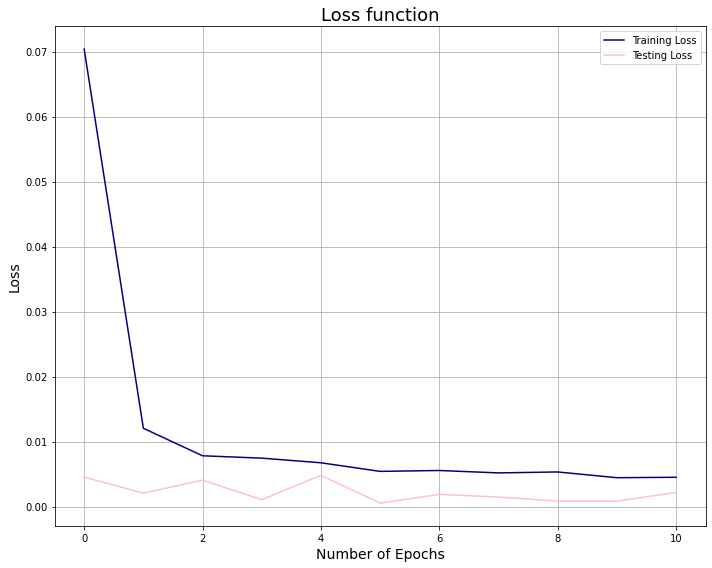

<Figure size 432x288 with 0 Axes>

In [99]:
# Plotting Loss function
train_loss_SPY = history_SPY.history['loss']
test_loss_SPY = history_SPY.history['val_loss']

plt.figure(figsize=(10,8))
plt.plot(train_loss_SPY, label='Training Loss', color='navy')
plt.plot(test_loss_SPY, label='Testing Loss', color='pink')
plt.legend()

plt.title('Loss function', size=18)
plt.xlabel('Number of Epochs', size=14)
plt.ylabel('Loss', size=14)
plt.grid()
plt.tight_layout()
plt.show()

# Saving the figure
plt.savefig('./images/LSTM_loss_fx_SPY_mv.png');

In [100]:
# Forecasting
# Currently, test set has 554 days to the end of Dec. 2021. Would like to see more into Jan. 2022.
days_future = 837
# Starting with the last day in the training dataset and above-defined days into the future. 
forecast_dates_SPY = pd.date_range(list(train_dates)[-1], periods=days_future, freq='1d').tolist()
# Forecast
forecast_SPY = model_SPY.predict(X_train_SPY[-days_future: ])

# Inverse transform to obtain the interpretable price data from the forecast.
# Consider this one is a multivariate model, need to make sure the number of columns match between input and output.
y_pred_SPY = scaler.inverse_transform(np.repeat(forecast_SPY, df_LSTM_train_SPY.shape[1], axis=-1))[:, 0]

# Converting timestamp to date
forecast_dates = []
for i in forecast_dates_SPY:
    forecast_dates.append(i.date())

df_forecast_SPY = pd.DataFrame({'Date': np.array(forecast_dates), 'Adj_Close_SPY': y_pred_SPY})
df_forecast_SPY['Date'] = pd.to_datetime(df_forecast_SPY['Date'])
df_forecast_SPY.set_index('Date', inplace=True)

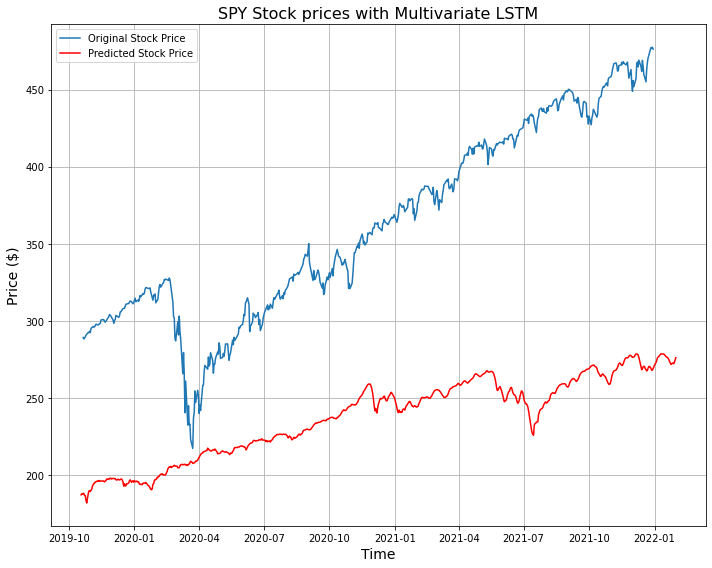

<Figure size 432x288 with 0 Axes>

In [101]:
# Plotting 
plt.figure(figsize=(10,8))
plt.plot(df_LSTM_test_SPY.index, df_LSTM_test_SPY['Adj_Close_SPY'], label='Original Stock Price')
plt.plot(df_forecast_SPY.index, df_forecast_SPY['Adj_Close_SPY'], label='Predicted Stock Price', color='r')

plt.title('SPY Stock prices with Multivariate LSTM', size=16)
plt.xlabel('Time', size=14)
plt.ylabel('Price ($)', size=14)
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

# Saving the figure
plt.savefig('./images/LSTM_fc_SPY_mv.png');

##### Univariate Model - Adjusted Closing Price only

In [102]:
# Setting train/test dataframe for SPY
df_LSTM_train_SPY = df_LSTM_train[['Adj_Close_SPY', 'Volume_SPY', 'SPY_daily_pct_change']]
df_LSTM_test_SPY = df_LSTM_test[['Adj_Close_SPY', 'Volume_SPY', 'SPY_daily_pct_change']]

# Instantiate MinMaxScaler
scaler = MinMaxScaler()

# Fit & transform the training data
df_LSTM_train_scaled_SPY = scaler.fit_transform(df_LSTM_train_SPY)

# Setting X & Y train
X_train_SPY = []
y_train_SPY = []

# Number of days to be predicted 
days_future = 1
# Number of days in the past to be used for future prediction. On average, there are 253 trading days in a year.
days_past = 5

for i in range(days_past, len(df_LSTM_train_scaled_SPY) - days_future + 1):
    X_train_SPY.append(df_LSTM_train_scaled_SPY[i - days_past:i, 0 : df_LSTM_train_SPY.shape[1]])
    y_train_SPY.append(df_LSTM_train_scaled_SPY[i + days_future - 1 : i + days_future, 0])
    
# Converting X & y train into array
X_train_SPY, y_train_SPY = np.array(X_train_SPY), np.array(y_train_SPY)
# Printing shape of X & y train after converting to array.
print('Notice the difference in the number of rows (holding period 5)')
print('X_train_SPY:', X_train_SPY.shape), print('y_train_SPY:', y_train_SPY.shape)

Notice the difference in the number of rows (holding period 5)
X_train_SPY: (2209, 5, 3)
y_train_SPY: (2209, 1)


(None, None)

In [103]:
# Instantiating the model
model_SPY = Sequential()

# First Layer. return_sequences set to true because we want this LSTM to return a sequence for the next LSTM. We have stacked LSTM. 
model_SPY.add(LSTM(units=50, activation='relu', return_sequences=True, input_shape=(X_train_SPY.shape[1], X_train_SPY.shape[2])))
model_SPY.add(Dropout(0.2))

# Second layer
model_SPY.add(LSTM(units=60, activation='relu', return_sequences=True))
model_SPY.add(Dropout(0.3))

# Third layer
model_SPY.add(LSTM(units=80, activation='relu', return_sequences=True))
model_SPY.add(Dropout(0.4))

# Fourth layer
model_SPY.add(LSTM(units=120, activation='relu'))
model_SPY.add(Dropout(0.5))

# Dense Layer - to connect all the layers
model_SPY.add(Dense(y_train_SPY.shape[1]))

# Model Summary
print(model_SPY.summary())

# Compiling the models. Keeping the loss as MSE for Time-Series analysis
model_SPY.compile(optimizer='adam', loss='mean_squared_error')

# Adding EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')
# Fitting the model on training data with early stopping
# Using 10% of the training data as validation set.
history_SPY = model_SPY.fit(X_train_SPY, y_train_SPY, validation_split=0.1, epochs=50, callbacks=[early_stop])

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_24 (LSTM)              (None, 5, 50)             10800     
                                                                 
 dropout_24 (Dropout)        (None, 5, 50)             0         
                                                                 
 lstm_25 (LSTM)              (None, 5, 60)             26640     
                                                                 
 dropout_25 (Dropout)        (None, 5, 60)             0         
                                                                 
 lstm_26 (LSTM)              (None, 5, 80)             45120     
                                                                 
 dropout_26 (Dropout)        (None, 5, 80)             0         
                                                                 
 lstm_27 (LSTM)              (None, 120)              

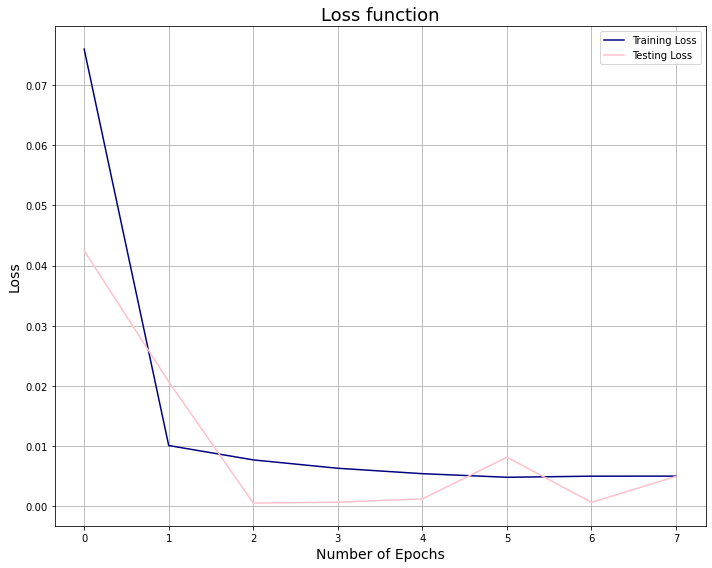

<Figure size 432x288 with 0 Axes>

In [104]:
# Plotting Loss function
train_loss_SPY = history_SPY.history['loss']
test_loss_SPY = history_SPY.history['val_loss']

plt.figure(figsize=(10,8))
plt.plot(train_loss_SPY, label='Training Loss', color='navy')
plt.plot(test_loss_SPY, label='Testing Loss', color='pink')
plt.legend()

plt.title('Loss function', size=18)
plt.xlabel('Number of Epochs', size=14)
plt.ylabel('Loss', size=14)
plt.grid()
plt.tight_layout()
plt.show()

# Saving the figure
plt.savefig('./images/LSTM_loss_fx_SPY_uv.png');

In [105]:
# Forecasting
# Currently, test set has 554 days to the end of Dec. 2021. Would like to see more into Jan. 2022.
days_future = 837
# Starting with the last day in the training dataset and above-defined days into the future. 
forecast_dates_SPY = pd.date_range(list(train_dates)[-1], periods=days_future, freq='1d').tolist()
# Forecast
forecast_SPY = model_SPY.predict(X_train_SPY[-days_future: ])

# Inverse transform to obtain the interpretable price data from the forecast.
# Consider this one is a multivariate model, need to make sure the number of columns match between input and output.
y_pred_SPY = scaler.inverse_transform(np.repeat(forecast_SPY, df_LSTM_train_SPY.shape[1], axis=-1))[:, 0]

# Converting timestamp to date
forecast_dates = []
for i in forecast_dates_SPY:
    forecast_dates.append(i.date())

df_forecast_SPY_UV = pd.DataFrame({'Date': np.array(forecast_dates), 'Adj_Close_SPY': y_pred_SPY})
df_forecast_SPY_UV['Date'] = pd.to_datetime(df_forecast_SPY_UV['Date'])
df_forecast_SPY_UV.set_index('Date', inplace=True)

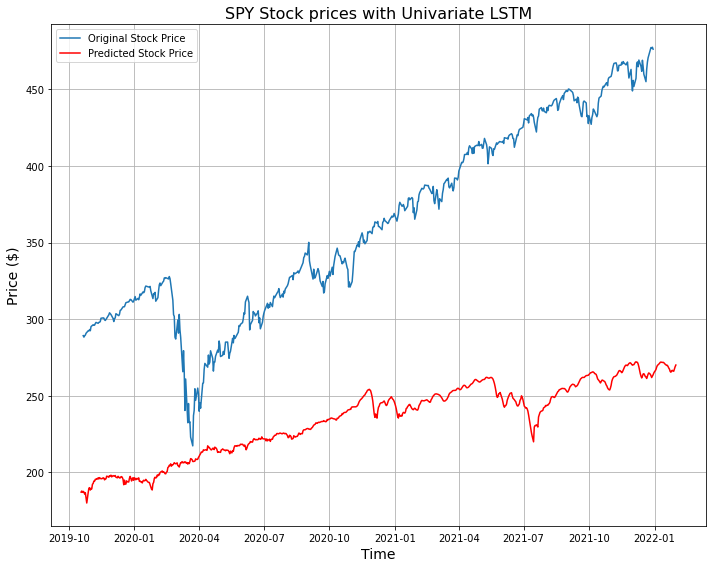

<Figure size 432x288 with 0 Axes>

In [106]:
# Plotting 
plt.figure(figsize=(10,8))
plt.plot(df_LSTM_test_SPY.index, df_LSTM_test_SPY['Adj_Close_SPY'], label='Original Stock Price')
plt.plot(df_forecast_SPY_UV.index, df_forecast_SPY_UV['Adj_Close_SPY'], label='Predicted Stock Price', color='r')

plt.title('SPY Stock prices with Univariate LSTM', size=16)
plt.xlabel('Time', size=14)
plt.ylabel('Price ($)', size=14)
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

# Saving the figure
plt.savefig('./images/LSTM_fc_SPY_uv.png');

#### TSLA - Tesla

In [107]:
# Setting train/test dataframe for TSLA
df_LSTM_train_TSLA = df_LSTM_train[['Adj_Close_TSLA', 'Volume_TSLA', 'TSLA_daily_pct_change']]
df_LSTM_test_TSLA = df_LSTM_test[['Adj_Close_TSLA', 'Volume_TSLA', 'TSLA_daily_pct_change']]

# Instantiate MinMaxScaler
scaler = MinMaxScaler()

# Fit & transform the training data
df_LSTM_train_scaled_TSLA = scaler.fit_transform(df_LSTM_train_TSLA)

# Setting X & Y train
X_train_TSLA = []
y_train_TSLA = []

# Number of days to be predicted 
days_future = 1
# Number of days in the past to be used for future prediction. Picking 5 trading days for the previous week (Rolling 5 days = 1 trading week)
days_past = 5

for i in range(days_past, len(df_LSTM_train_scaled_TSLA) - days_future + 1):
    X_train_TSLA.append(df_LSTM_train_scaled_TSLA[i - days_past:i, 0 : df_LSTM_train_TSLA.shape[1]])
    y_train_TSLA.append(df_LSTM_train_scaled_TSLA[i + days_future - 1 : i + days_future, 0])
    
# Converting X & y train into array
X_train_TSLA, y_train_TSLA = np.array(X_train_TSLA), np.array(y_train_TSLA)
# Printing shape of X & y train after converting to array.
print('Notice the difference in the number of rows (holding period 5)')
print('X_train_TSLA:', X_train_TSLA.shape), print('y_train_TSLA:', y_train_TSLA.shape);

Notice the difference in the number of rows (holding period 5)
X_train_TSLA: (2209, 5, 3)
y_train_TSLA: (2209, 1)


In [108]:
# Instantiating the model
model_TSLA = Sequential()

# First Layer. return_sequences set to true because we want this LSTM to return a sequence for the next LSTM. We have stacked LSTM. 
model_TSLA.add(LSTM(units=50, activation='relu', return_sequences=True, input_shape=(X_train_TSLA.shape[1], X_train_TSLA.shape[2])))
model_TSLA.add(Dropout(0.2))

# Second layer
model_TSLA.add(LSTM(units=60, activation='relu', return_sequences=True))
model_TSLA.add(Dropout(0.3))

# Third layer
model_TSLA.add(LSTM(units=80, activation='relu', return_sequences=True))
model_TSLA.add(Dropout(0.4))

# Fourth layer
model_TSLA.add(LSTM(units=120, activation='relu'))
model_TSLA.add(Dropout(0.5))

# Dense Layer - to connect all the layers
model_TSLA.add(Dense(y_train_TSLA.shape[1]))

# Model Summary
print(model_TSLA.summary())

# Compiling the models. Keeping the loss as MSE for Time-Series analysis
model_TSLA.compile(optimizer='adam', loss='mean_squared_error')

# Adding EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')
# Fitting the model on training data with early stopping
# Using 10% of the training data as validation set.
history_TSLA = model_TSLA.fit(X_train_TSLA, y_train_TSLA, validation_split=0.1, epochs=50, callbacks=[early_stop])

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_28 (LSTM)              (None, 5, 50)             10800     
                                                                 
 dropout_28 (Dropout)        (None, 5, 50)             0         
                                                                 
 lstm_29 (LSTM)              (None, 5, 60)             26640     
                                                                 
 dropout_29 (Dropout)        (None, 5, 60)             0         
                                                                 
 lstm_30 (LSTM)              (None, 5, 80)             45120     
                                                                 
 dropout_30 (Dropout)        (None, 5, 80)             0         
                                                                 
 lstm_31 (LSTM)              (None, 120)              

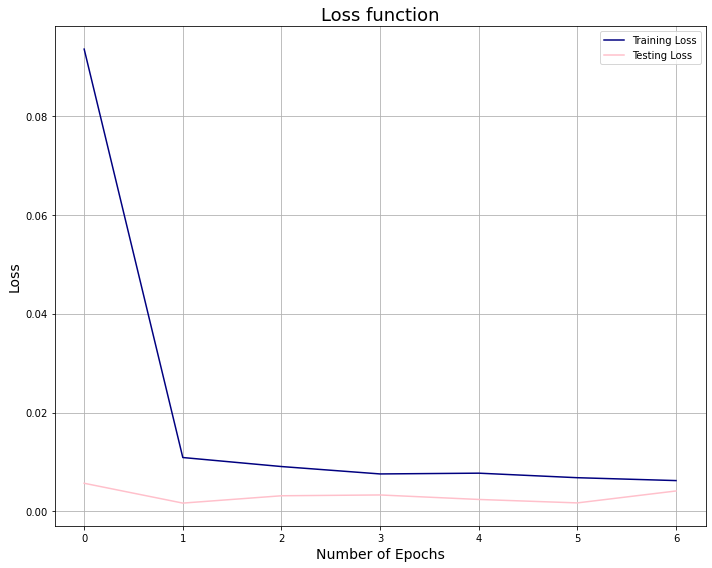

<Figure size 432x288 with 0 Axes>

In [109]:
# Plotting Loss function
train_loss_TSLA = history_TSLA.history['loss']
test_loss_TSLA = history_TSLA.history['val_loss']

plt.figure(figsize=(10,8))
plt.plot(train_loss_TSLA, label='Training Loss', color='navy')
plt.plot(test_loss_TSLA, label='Testing Loss', color='pink')
plt.legend()

plt.title('Loss function', size=18)
plt.xlabel('Number of Epochs', size=14)
plt.ylabel('Loss', size=14)
plt.grid()
plt.tight_layout()
plt.show()

# Saving the figure
plt.savefig('./images/LSTM_loss_fx_TSLA.png');

In [110]:
# Forecasting
# Currently, test set has 554 days to the end of Dec. 2021. Would like to see more into Jan. 2022.
days_future = 837
# Starting with the last day in the training dataset and above-defined days into the future. 
forecast_dates_TSLA = pd.date_range(list(train_dates)[-1], periods=days_future, freq='1d').tolist()
# Forecast
forecast_TSLA = model_TSLA.predict(X_train_TSLA[-days_future: ])

# Inverse transform to obtain the interpretable price data from the forecast.
# Consider this one is a multivariate model, need to make sure the number of columns match between input and output.
y_pred_TSLA = scaler.inverse_transform(np.repeat(forecast_TSLA, df_LSTM_train_TSLA.shape[1], axis=-1))[:, 0]

# Converting timestamp to date
forecast_dates = []
for i in forecast_dates_TSLA:
    forecast_dates.append(i.date())

df_forecast_TSLA = pd.DataFrame({'Date': np.array(forecast_dates), 'Adj_Close_TSLA': y_pred_TSLA})
df_forecast_TSLA['Date'] = pd.to_datetime(df_forecast_TSLA['Date'])
df_forecast_TSLA.set_index('Date', inplace=True)

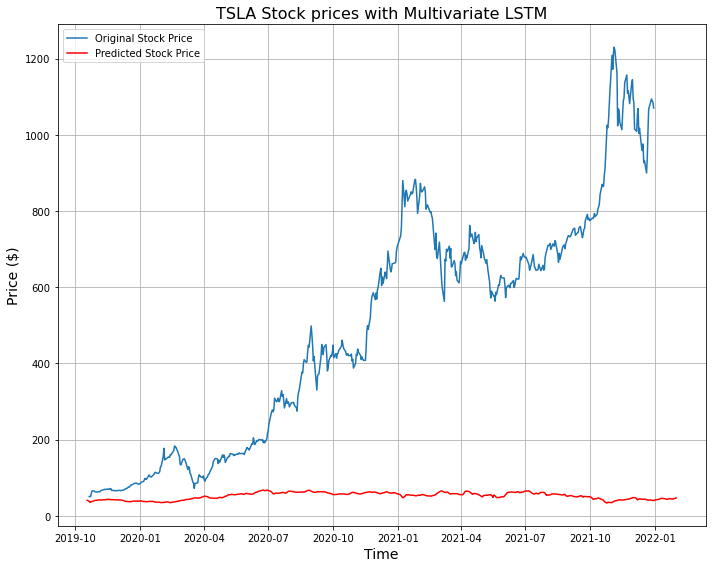

<Figure size 432x288 with 0 Axes>

In [111]:
# Plotting 
plt.figure(figsize=(10,8))
plt.plot(df_LSTM_test_TSLA.index, df_LSTM_test_TSLA['Adj_Close_TSLA'], label='Original Stock Price')
plt.plot(df_forecast_TSLA.index, df_forecast_TSLA['Adj_Close_TSLA'], label='Predicted Stock Price', color='r')

plt.title('TSLA Stock prices with Multivariate LSTM', size=16)
plt.xlabel('Time', size=14)
plt.ylabel('Price ($)', size=14)
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

# Saving the figure
plt.savefig('./images/LSTM_fc_TSLA.png');

#### VIX

In [112]:
# Setting train/test dataframe for VIX
df_LSTM_train_VIX = df_LSTM_train[['Adj_Close_VIX', 'VIX_daily_pct_change']]
df_LSTM_test_VIX = df_LSTM_test[['Adj_Close_VIX', 'VIX_daily_pct_change']]

# Instantiate MinMaxScaler
scaler = MinMaxScaler()

# Fit & transform the training data
df_LSTM_train_scaled_VIX = scaler.fit_transform(df_LSTM_train_VIX)

# Setting X & Y train
X_train_VIX = []
y_train_VIX = []

# Number of days to be predicted 
days_future = 1
# Number of days in the past to be used for future prediction. Picking 5 trading days for the previous week (Rolling 5 days = 1 trading week)
days_past = 5

for i in range(days_past, len(df_LSTM_train_scaled_VIX) - days_future + 1):
    X_train_VIX.append(df_LSTM_train_scaled_VIX[i - days_past:i, 0 : df_LSTM_train_VIX.shape[1]])
    y_train_VIX.append(df_LSTM_train_scaled_VIX[i + days_future - 1 : i + days_future, 0])
    
# Converting X & y train into array
X_train_VIX, y_train_VIX = np.array(X_train_VIX), np.array(y_train_VIX)
# Printing shape of X & y train after converting to array.
print('Notice the difference in the number of rows (holding period 5)')
print('X_train_VIX:', X_train_VIX.shape), print('y_train_VIX:', y_train_VIX.shape);

Notice the difference in the number of rows (holding period 5)
X_train_VIX: (2209, 5, 2)
y_train_VIX: (2209, 1)


In [113]:
# Instantiating the model
model_VIX = Sequential()

# First Layer. return_sequences set to true because we want this LSTM to return a sequence for the next LSTM. We have stacked LSTM. 
model_VIX.add(LSTM(units=50, activation='relu', return_sequences=True, input_shape=(X_train_VIX.shape[1], X_train_VIX.shape[2])))
model_VIX.add(Dropout(0.2))

# Second layer
model_VIX.add(LSTM(units=60, activation='relu', return_sequences=True))
model_VIX.add(Dropout(0.3))

# Third layer
model_VIX.add(LSTM(units=80, activation='relu', return_sequences=True))
model_VIX.add(Dropout(0.4))

# Fourth layer
model_VIX.add(LSTM(units=120, activation='relu'))
model_VIX.add(Dropout(0.5))

# Dense Layer - to connect all the layers
model_VIX.add(Dense(y_train_VIX.shape[1]))

# Model Summary
print(model_VIX.summary())

# Compiling the models. Keeping the loss as MSE for Time-Series analysis
model_VIX.compile(optimizer='adam', loss='mean_squared_error')

# Adding EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')
# Fitting the model on training data with early stopping
# Using 10% of the training data as validation set.
history_VIX = model_VIX.fit(X_train_VIX, y_train_VIX, validation_split=0.1, epochs=50, callbacks=[early_stop])

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_32 (LSTM)              (None, 5, 50)             10600     
                                                                 
 dropout_32 (Dropout)        (None, 5, 50)             0         
                                                                 
 lstm_33 (LSTM)              (None, 5, 60)             26640     
                                                                 
 dropout_33 (Dropout)        (None, 5, 60)             0         
                                                                 
 lstm_34 (LSTM)              (None, 5, 80)             45120     
                                                                 
 dropout_34 (Dropout)        (None, 5, 80)             0         
                                                                 
 lstm_35 (LSTM)              (None, 120)              

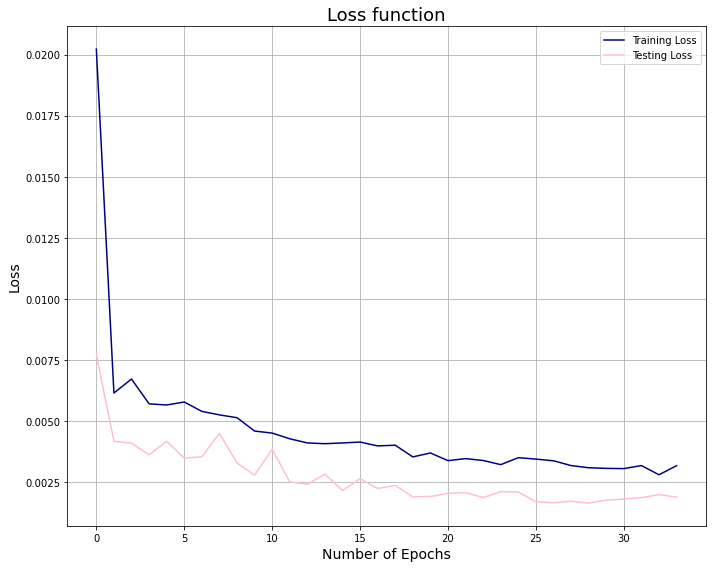

<Figure size 432x288 with 0 Axes>

In [114]:
# Plotting Loss function
train_loss_VIX = history_VIX.history['loss']
test_loss_VIX = history_VIX.history['val_loss']

plt.figure(figsize=(10,8))
plt.plot(train_loss_VIX, label='Training Loss', color='navy')
plt.plot(test_loss_VIX, label='Testing Loss', color='pink')
plt.legend()

plt.title('Loss function', size=18)
plt.xlabel('Number of Epochs', size=14)
plt.ylabel('Loss', size=14)
plt.grid()
plt.tight_layout()
plt.show()

# Saving the figure
plt.savefig('./images/LSTM_loss_fx_VIX.png');

In [115]:
# Forecasting
# Currently, test set has 554 days to the end of Dec. 2021. Would like to see more into Jan. 2022.
days_future = 837
# Starting with the last day in the training dataset and above-defined days into the future. 
forecast_dates_VIX = pd.date_range(list(train_dates)[-1], periods=days_future, freq='1d').tolist()
# Forecast
forecast_VIX = model_VIX.predict(X_train_VIX[-days_future: ])

# Inverse transform to obtain the interpretable price data from the forecast.
# Consider this one is a multivariate model, need to make sure the number of columns match between input and output.
y_pred_VIX = scaler.inverse_transform(np.repeat(forecast_VIX, df_LSTM_train_VIX.shape[1], axis=-1))[:, 0]

# Converting timestamp to date
forecast_dates = []
for i in forecast_dates_VIX:
    forecast_dates.append(i.date())

df_forecast_VIX = pd.DataFrame({'Date': np.array(forecast_dates), 'Adj_Close_VIX': y_pred_VIX})
df_forecast_VIX['Date'] = pd.to_datetime(df_forecast_VIX['Date'])
df_forecast_VIX.set_index('Date', inplace=True)

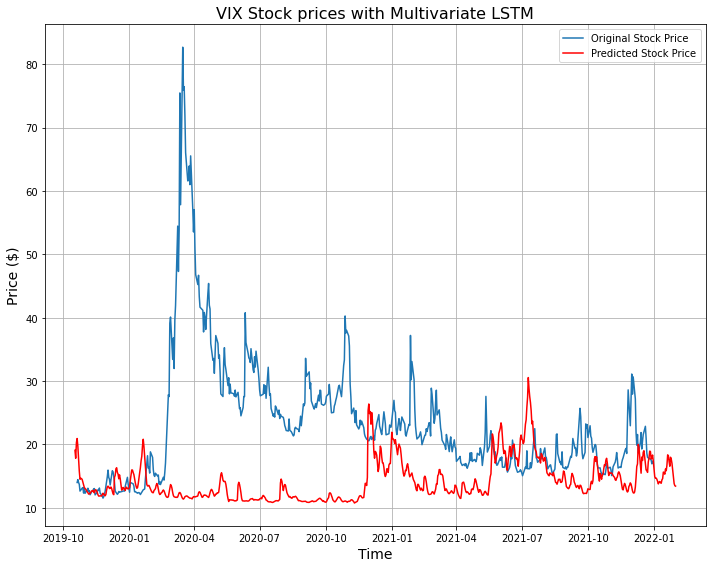

<Figure size 432x288 with 0 Axes>

In [116]:
# Plotting 
plt.figure(figsize=(10,8))
plt.plot(df_LSTM_test_VIX.index, df_LSTM_test_VIX['Adj_Close_VIX'], label='Original Stock Price')
plt.plot(df_forecast_VIX.index, df_forecast_VIX['Adj_Close_VIX'], label='Predicted Stock Price', color='r')

plt.title('VIX Stock prices with Multivariate LSTM', size=16)
plt.xlabel('Time', size=14)
plt.ylabel('Price ($)', size=14)
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

# Saving the figure
plt.savefig('./images/LSTM_fc_VIX.png');

#### LSTM Stock prices combined

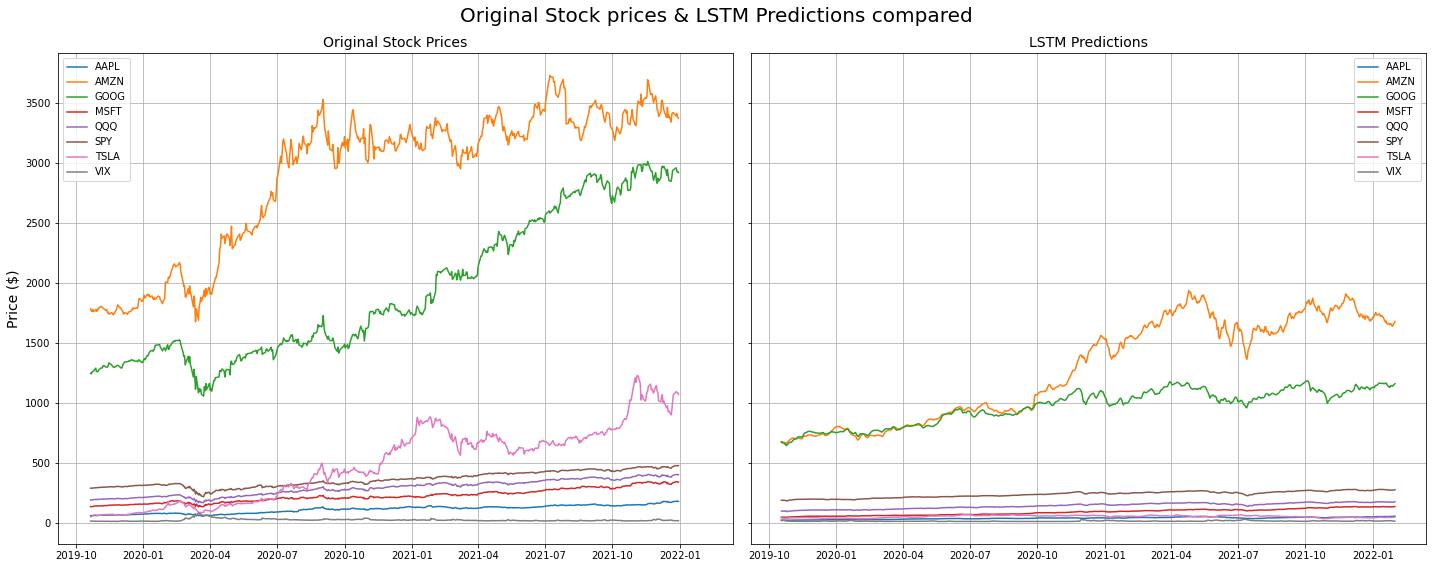

In [117]:
fig, axs = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(20,8))
fig.suptitle('Original Stock prices & LSTM Predictions compared', size=20)

axs[0].plot(df_LSTM_test['Adj_Close_AAPL'], label='AAPL')
axs[0].plot(df_LSTM_test['Adj_Close_AMZN'], label='AMZN')
axs[0].plot(df_LSTM_test['Adj_Close_GOOG'], label='GOOG')
axs[0].plot(df_LSTM_test['Adj_Close_MSFT'], label='MSFT')
axs[0].plot(df_LSTM_test['Adj_Close_QQQ'], label='QQQ')
axs[0].plot(df_LSTM_test['Adj_Close_SPY'], label='SPY')
axs[0].plot(df_LSTM_test['Adj_Close_TSLA'], label='TSLA')
axs[0].plot(df_LSTM_test['Adj_Close_VIX'], label='VIX')
axs[0].set_title('Original Stock Prices', size=14)
axs[0].set_ylabel('Price ($)', size=14)
axs[0].legend()
axs[0].grid()

axs[1].plot(df_forecast_AAPL['Adj_Close_AAPL'], label='AAPL')
axs[1].plot(df_forecast_AMZN['Adj_Close_AMZN'], label='AMZN')
axs[1].plot(df_forecast_GOOG['Adj_Close_GOOG'], label='GOOG')
axs[1].plot(df_forecast_MSFT['Adj_Close_MSFT'], label='MSFT')
axs[1].plot(df_forecast_QQQ['Adj_Close_QQQ'], label='QQQ')
axs[1].plot(df_forecast_SPY['Adj_Close_SPY'], label='SPY')
axs[1].plot(df_forecast_TSLA['Adj_Close_TSLA'], label='TSLA')
axs[1].plot(df_forecast_VIX['Adj_Close_VIX'], label='VIX')
axs[1].set_title('LSTM Predictions', size=14)
axs[1].legend()
axs[1].grid()

plt.tight_layout()
plt.savefig('./images/LSTM_forecasts_combined.png')

## Models with shorter time period
As shown in the above results, the models (Auto-ARIMA, VAR, and LSTM) returned the predictions that are rather underperforming than the expectation. The original expectation was that the more data trained, the more accurate prediction yielded. This does not seem to be the case here. It seems due to recent explosive growth in the stock market compared to past many years, the models trained on the old historical data are not picking up/catching up with the recent trend in the price changes. Here, each models will be revisited with shorter amount of time period provided for the training and see how the results compare. 

In this section, S&P 500 ETF, **SPY** will be examined with data from 2020-2021. 

### Data Resampling 
Sorting SPY data from the original datasets. Data will be used from 2020 to 2021. On New Year's Day, stock market is closed. 

In [118]:
# Getting SPY-related data from 2020 and 2021 only. Will utilize adjusted closing price, volume, and daily percentage change. 
df_SPY = df[['Adj_Close_SPY', 'Volume_SPY', 'SPY_daily_pct_change']][2264:].copy()

In [119]:
# Checking the first two days in dataframe
df_SPY.head(2)

,Adj_Close_SPY,Volume_SPY,SPY_daily_pct_change
Date,,,
2020-01-02,314.719147,59151200,0.935171
2020-01-03,312.336029,77709700,-0.757220


In [120]:
# Checking the last two days in dataframe. 
df_SPY.tail(2)

,Adj_Close_SPY,Volume_SPY,SPY_daily_pct_change
Date,,,
2021-12-29,477.480011,54503000,0.127921
2021-12-30,476.160004,55329000,-0.276453


### Train / Test Split

In [121]:
# Finding out the length of the dataframe. Will perform 80:20 split.
len(df_SPY), round(len(df_SPY)*0.8), round(len(df_SPY)*0.2)

(504, 403, 101)

In [122]:
df_SPY_train = df_SPY.iloc[ :403]
df_SPY_test = df_SPY.iloc[403: ]

In [123]:
df_SPY_train.tail(1)

,Adj_Close_SPY,Volume_SPY,SPY_daily_pct_change
Date,,,
2021-08-06,439.532745,46864100,0.165243


In [124]:
df_SPY_test.head(1)

,Adj_Close_SPY,Volume_SPY,SPY_daily_pct_change
Date,,,
2021-08-09,439.17514,41222600,-0.08136


08/06/2021 was Friday and 08/09/2021 was Monday, so the trading days add up.

### Auto-ARIMA model

In [125]:
# Adjusting previous Auto-ARIMA function to adapt to dataframe change. 
def auto_arima_work(ticker):
    print('*' * 70)
    print(f'This is auto-ARIMA model for {ticker}')
    ticker=str(ticker)
    # Instantiate the model
    model = auto_arima(df_SPY_train[f'Adj_Close_{ticker}'], test='adf')
    # Show model summary
    print(model.summary())

    # Plotting diagnostics
    model.plot_diagnostics(figsize=(10,8))
    plt.show()

    # Forecasting. Train set has 403 rows and Test set has 101 rows.
    forecast, conf_int = model.predict(n_periods=101, return_conf_int=True)

    # Creating series for forecasting
    forecast_series = pd.Series(forecast, index=df_SPY_test.index)
    lower_bound = pd.Series(conf_int[:, 0], index=df_SPY_test.index)
    upper_bound = pd.Series(conf_int[:, 1], index=df_SPY_test.index)

    # Plotting
    plt.figure(figsize=(10,8))
    
    plt.plot(df_SPY_train[f'Adj_Close_{ticker}'], label='Train (Actual Data)')
    plt.plot(df_SPY_test[f'Adj_Close_{ticker}'], label='Test (Actual Data)')
    
    plt.plot(forecast_series, color='black', label='Forecast Price (Auto-ARIMA)')
    
    plt.fill_between(x=df_SPY_test.index, y1=lower_bound, y2=upper_bound, color='k', alpha=0.15)
    
    plt.plot(lower_bound, color='r', label='Forecast Lowerbound')
    plt.plot(upper_bound, color='g', label='Forecast Upperbound')
    plt.grid()
    plt.title(f'Stock Price for {ticker}', size=20)
    plt.xlabel('Time', size=14)
    plt.ylabel('Price ($)', size=14)
    plt.legend()
    # Saving the figure
    plt.savefig(f'./images/Auto_ARIMA_fc_short_{ticker}.png');

**********************************************************************
This is auto-ARIMA model for SPY
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  403
Model:               SARIMAX(0, 1, 2)   Log Likelihood               -1198.921
Date:                Sat, 05 Feb 2022   AIC                           2403.842
Time:                        15:51:15   BIC                           2415.831
Sample:                             0   HQIC                          2408.589
                                - 403                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2018      0.028     -7.141      0.000      -0.257      -0.146
ma.L2          0.2191      

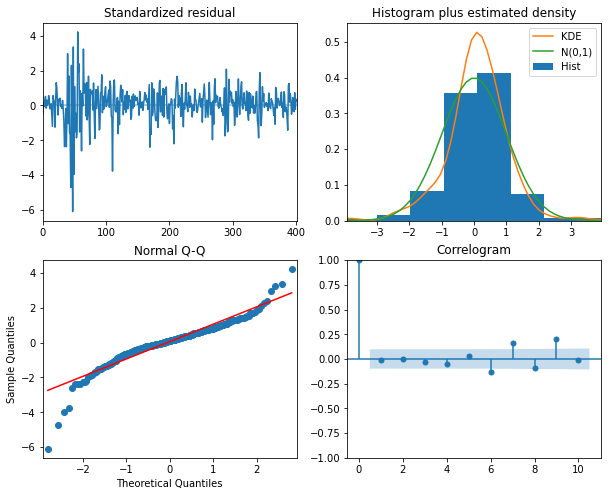

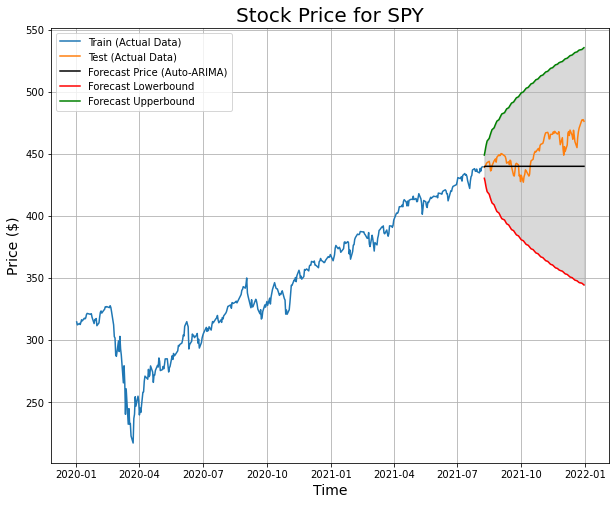

In [126]:
auto_arima_work('SPY')

### VAR model

In [127]:
# Instantiate VAR with train set
SPY_VAR = VAR(df_SPY_train)

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [128]:
# Compute lag order selections based on each of the available information criteria
# Setting Maxlags = 50 and constant terms.
print(SPY_VAR.select_order(50).summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        43.79       43.82   1.041e+19       43.80
1        34.39       34.52   8.583e+14       34.44
2        34.20      34.43*   7.153e+14       34.30
3        34.18       34.51   6.964e+14       34.31
4        34.09       34.52   6.381e+14       34.26
5        33.98       34.51   5.727e+14       34.19
6        33.98       34.61   5.749e+14       34.23
7        33.88       34.61   5.202e+14      34.17*
8        33.88       34.70   5.171e+14       34.21
9       33.87*       34.79  5.151e+14*       34.24
10       33.90       34.92   5.287e+14       34.31
11       33.91       35.02   5.320e+14       34.35
12       33.93       35.15   5.449e+14       34.41
13       33.93       35.25   5.480e+14       34.46
14       33.96       35.38   5.643e+14       34.53
15       33.99       35.51   5.829e+14       34.60
16       33.98       35.59   5.

AIC is lowest at lag 9, BIC is lowest at lag 2, FPE is lowest at lag 9, HQIC is lowest at lag 7.
Will proceed with the **lowest lag**, 2.

In [129]:
# Resetting the model with the lowest lag
SPY_VAR = VAR(df_SPY_train)
# Results. Setting maxlags 2 here and it will use bic as VAR order selection.
results_SPY_VAR = SPY_VAR.fit(2)

# Summary of VAR
results_SPY_VAR.summary()

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 05, Feb, 2022
Time:                     15:51:16
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    34.8306
Nobs:                     401.000    HQIC:                   34.7042
Log likelihood:          -8627.57    FPE:                1.08613e+15
AIC:                      34.6214    Det(Omega_mle):     1.03118e+15
--------------------------------------------------------------------
Results for equation Adj_Close_SPY
                             coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------------
const                           2.031423         2.217101            0.916           0.360
L1.Adj_Close_SPY                1.703453         0.301834            5.644           0.000
L1.Volume_SP

In [130]:
# Obtaining the lag
lag_SPY_VAR = results_SPY_VAR.k_ar
lag_SPY_VAR

2

In [131]:
# Forecasting - We need the data to lag by "lag_VAR" to predict the next value. 
df_SPY_pred = pd.DataFrame(results_SPY_VAR.forecast(df_SPY_train.values[-lag_SPY_VAR: ], steps=101), index=df_SPY_test.index, columns=df_SPY_train.columns)
df_SPY_pred.tail()

,Adj_Close_SPY,Volume_SPY,SPY_daily_pct_change
Date,,,
2021-12-23,457.842190,4.811756e+07,-0.022606
2021-12-27,458.010069,4.805248e+07,-0.022792
2021-12-28,458.177725,4.798748e+07,-0.022978
2021-12-29,458.345159,4.792257e+07,-0.023163
2021-12-30,458.512372,4.785774e+07,-0.023348


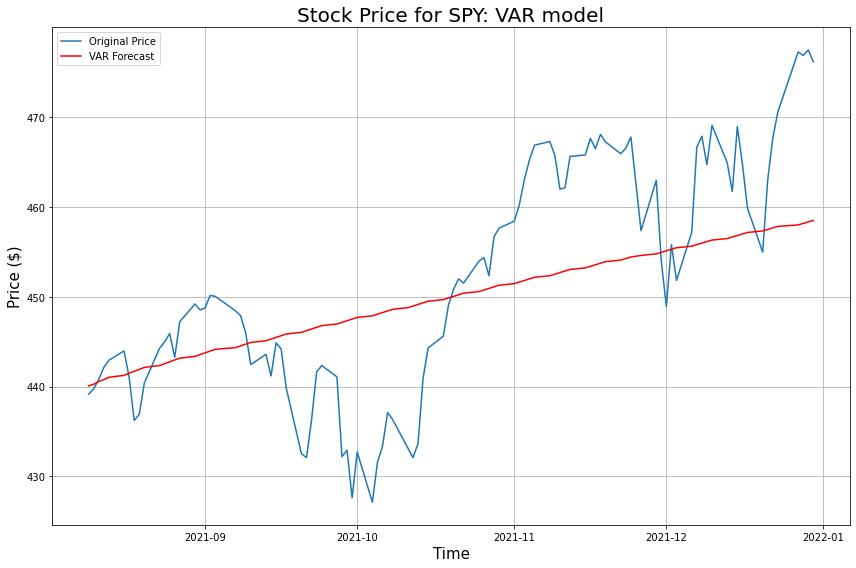

In [132]:
plt.figure(figsize=(12,8))
plt.plot(df_SPY_test['Adj_Close_SPY'], label='Original Price')
plt.plot(df_SPY_pred['Adj_Close_SPY'], label='VAR Forecast', color='r')
plt.title('Stock Price for SPY: VAR model', size=20)
plt.xlabel('Time', size=15)
plt.ylabel('Price ($)', size=15)
plt.legend()
plt.grid()
plt.tight_layout()

# Saving the figure
plt.savefig('./images/VAR_fc_short_SPY.png')

### LSTM model - Multivariate

In [133]:
# Instantiate MinMaxScaler
scaler = MinMaxScaler()

# Fit & transform the training data
df_SPY_train_scaled = scaler.fit_transform(df_SPY_train)

# Setting X & Y train
X_train_SPY = []
y_train_SPY = []

# Number of days to be predicted 
days_future = 1
# Number of days in the past to be used for future prediction. Picking 5 trading days for the previous week (Rolling 5 days = 1 trading week)
days_past = 5

for i in range(days_past, len(df_SPY_train_scaled) - days_future + 1):
    X_train_SPY.append(df_SPY_train_scaled[i - days_past:i, 0 : df_SPY_train_scaled.shape[1]])
    y_train_SPY.append(df_SPY_train_scaled[i + days_future - 1 : i + days_future, 0])
    
# Converting X & y train into array
X_train_SPY, y_train_SPY = np.array(X_train_SPY), np.array(y_train_SPY)

# Printing shape of X & y train after converting to array.
print('Notice the difference in the number of rows (holding period 5)')
print('X_train_SPY:', X_train_SPY.shape), print('y_train_SPY:', y_train_SPY.shape);

Notice the difference in the number of rows (holding period 5)
X_train_SPY: (398, 5, 3)
y_train_SPY: (398, 1)


In [134]:
# Instantiating the model
model_SPY = Sequential()

# First Layer. return_sequences set to true because we want this LSTM to return a sequence for the next LSTM. We have stacked LSTM. 
model_SPY.add(LSTM(units=50, activation='relu', return_sequences=True, input_shape=(X_train_SPY.shape[1], X_train_SPY.shape[2])))
model_SPY.add(Dropout(0.2))

# Second layer
model_SPY.add(LSTM(units=60, activation='relu', return_sequences=True))
model_SPY.add(Dropout(0.3))

# Third layer
model_SPY.add(LSTM(units=80, activation='relu', return_sequences=True))
model_SPY.add(Dropout(0.4))

# Fourth layer
model_SPY.add(LSTM(units=120, activation='relu'))
model_SPY.add(Dropout(0.5))

# Dense Layer - to connect all the layers
model_SPY.add(Dense(y_train_SPY.shape[1]))

# Model Summary
print(model_SPY.summary())

# Compiling the models. Keeping the loss as MSE for Time-Series analysis
model_SPY.compile(optimizer='adam', loss='mean_squared_error')

# Adding EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')
# Fitting the model on training data with early stopping
# Using 10% of the training data as validation set.
history_SPY = model_SPY.fit(X_train_SPY, y_train_SPY, validation_split=0.1, epochs=50, callbacks=[early_stop])

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_36 (LSTM)              (None, 5, 50)             10800     
                                                                 
 dropout_36 (Dropout)        (None, 5, 50)             0         
                                                                 
 lstm_37 (LSTM)              (None, 5, 60)             26640     
                                                                 
 dropout_37 (Dropout)        (None, 5, 60)             0         
                                                                 
 lstm_38 (LSTM)              (None, 5, 80)             45120     
                                                                 
 dropout_38 (Dropout)        (None, 5, 80)             0         
                                                                 
 lstm_39 (LSTM)              (None, 120)              

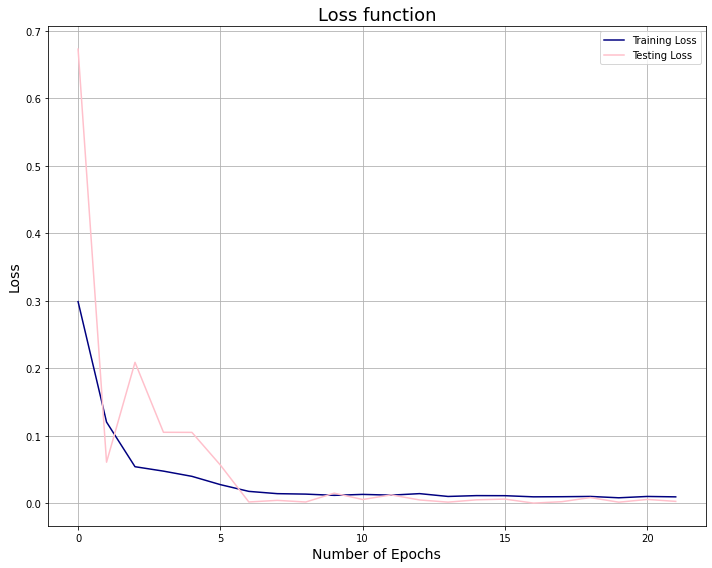

<Figure size 432x288 with 0 Axes>

In [135]:
# Plotting Loss function
train_loss_SPY = history_SPY.history['loss']
test_loss_SPY = history_SPY.history['val_loss']

plt.figure(figsize=(10,8))
plt.plot(train_loss_SPY, label='Training Loss', color='navy')
plt.plot(test_loss_SPY, label='Testing Loss', color='pink')
plt.legend()

plt.title('Loss function', size=18)
plt.xlabel('Number of Epochs', size=14)
plt.ylabel('Loss', size=14)
plt.grid()
plt.tight_layout()
plt.show()

# Saving the figure
plt.savefig('./images/LSTM_loss_fx_short_SPY.png');

In [136]:
# Forecasting
# Currently, test set has 101 days to the end of Dec. 2021.
days_future = 150
# Starting with the last day in the training dataset and above-defined days into the future. 
forecast_dates_SPY = pd.date_range(list(df_SPY_train.index)[-1], periods=days_future, freq='1d').tolist()
# Forecast
forecast_SPY = model_SPY.predict(X_train_SPY[-days_future: ])

# Inverse transform to obtain the interpretable price data from the forecast.
# Consider this one is a multivariate model, need to make sure the number of columns match between input and output.
y_pred_SPY = scaler.inverse_transform(np.repeat(forecast_SPY, df_SPY_train.shape[1], axis=-1))[:, 0]

# Converting timestamp to date
forecast_dates = []
for i in forecast_dates_SPY:
    forecast_dates.append(i.date())

df_forecast_SPY = pd.DataFrame({'Date': np.array(forecast_dates), 'Adj_Close_SPY': y_pred_SPY})
df_forecast_SPY['Date'] = pd.to_datetime(df_forecast_SPY['Date'])
df_forecast_SPY.set_index('Date', inplace=True)

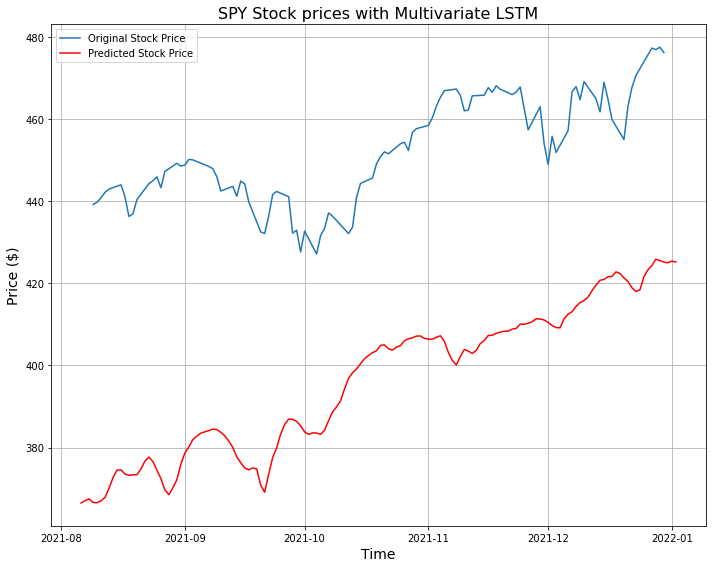

<Figure size 432x288 with 0 Axes>

In [138]:
# Plotting 
plt.figure(figsize=(10,8))
plt.plot(df_SPY_test.index, df_SPY_test['Adj_Close_SPY'], label='Original Stock Price')
plt.plot(df_forecast_SPY.index, df_forecast_SPY['Adj_Close_SPY'], label='Predicted Stock Price', color='r')

plt.title('SPY Stock prices with Multivariate LSTM', size=16)
plt.xlabel('Time', size=14)
plt.ylabel('Price ($)', size=14)
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

# Saving the figure
plt.savefig('./images/LSTM_fc_short_SPY_mv.png');